# **1. 데이터 불러오기(Colab)**

In [2]:
!mkdir data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
# os.chdir('../open')

In [5]:
!cp "/content/drive/MyDrive/project/data/train.csv" "/content/data/train.csv"
!cp "/content/drive/MyDrive/project/data/test.csv" "/content/data/test.csv"
!cp "/content/drive/MyDrive/project/data/sample_submission.csv" "/content/data/sample_submission.csv"

# **2. 라이브러리 설명**

In [ ]:
# 라이브러리 설치
!pip install catboost
!pip install category_encoders
!pip install imblearn
!pip install prince
!pip install optbinning
!pip install shap
!pip install optuna
!pip install eli5

# TabNet
!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'
!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

In [7]:
import warnings
warnings.filterwarnings('ignore') # 경고 메세지 제어

from tqdm.auto import tqdm # 작업 진행률 표시

import numpy as np # 행렬 연산
import pandas as pd # 데이터 분석

import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
plt.style.use('ggplot') # default plot style.

import itertools # 반복자
from scipy import stats # 확률 분포 분석
import prince # 다변량 분석

from imblearn.over_sampling import SMOTE # 불균형 데이터 처리

from optbinning import MulticlassOptimalBinning # 비닝

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import KBinsDiscretizer
import eli5
from eli5.sklearn import PermutationImportance

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch
from sklearn import preprocessing

# 범주형 변수 인코딩
import category_encoders as ce
"""
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
"""
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

In [8]:
train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")
sample_submission = pd.read_csv("/content/data/sample_submission.csv")

# **3. 데이터 탐색**

In [9]:
train.sample(n=5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
24671,24671,M,N,N,0,225000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-21729,-4249,1,1,1,1,Laborers,2.0,-8.0,2.0
23823,23823,M,N,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-20770,-623,1,1,0,0,Cooking staff,2.0,-13.0,1.0
13502,13502,F,N,Y,0,247500.0,Commercial associate,Higher education,Single / not married,House / apartment,-13788,-3822,1,1,1,0,Laborers,1.0,-40.0,2.0
7463,7463,M,N,N,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22486,365243,1,0,0,0,NaN,2.0,-3.0,0.0
14021,14021,F,N,Y,1,211500.0,Working,Secondary / secondary special,Married,House / apartment,-12585,-755,1,1,1,0,Core staff,3.0,-23.0,2.0


## Data feature description


- `index` : 제공된 데이터에서 같은 사용자여도 index는 다를 수 있습니다. (ex) 같은 사람이 복수의 카드를 발급할 경우)


- `gender` : 성별


- `car` : 차량 소유 여부


- `reality` : 부동산 소유 여부


- `child_num` : 자녀 수


- `income_total` : 연간 소득


- `income_type` : 소득 분류

    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']


- `edu_type` : 교육 수준

    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']


- `family_type` : 결혼 여부

    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']


- `house_type` : 생활 방식

    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']


- `DAYS_BIRTH` : 출생일

    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미


- `DAYS_EMPLOYED` : 업무 시작일

    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

    양수 값은 고용되지 않은 상태를 의미함


- `FLAG_MOBIL` : 핸드폰 소유 여부


- `work_phone` : 업무용 전화 소유 여부


- `phone` : 전화 소유 여부


- `email` : 이메일 소유 여부


- `occyp_type` : 직업 유형													


- `family_size` : 가족 규모


- `begin_month` : 신용카드 발급 월
			
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


- `credit` : 사용자의 신용카드 대금 연체를 기준의 신용도 ((Target))

    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [11]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [12]:
train.describe(include='O')

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
count,26457,26457,26457,26457,26457,26457,26457,18286
unique,2,2,2,5,5,5,6,18
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,17697,16410,17830,13645,17995,18196,23653,4512


# **4. 데이터 전처리**

## 중복 데이터 처리

In [13]:
train['idx'] = train['index']
test['idx'] = test['index']

# 전체 중복행 제거
train_not_dup_credit = train.drop_duplicates(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', 
                                              'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month','credit'], keep='first')

# credit만 다른 경우
credit_tot = train_not_dup_credit[train_not_dup_credit.duplicated(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', 
                                                                   'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month'], keep=False)]                                
# credit만 다르지 않은 경우
credit_not_dup = train_not_dup_credit[~train_not_dup_credit.index.isin(credit_tot.index)]

In [14]:
# 준지도학습 KNN 활용 시 코드
"""
train_knn = credit_not_dup.copy()
test_knn = credit_tot.copy()


train_knn['occyp_type'].fillna('None', inplace=True)
test_knn['occyp_type'].fillna('None', inplace=True)
cat_columns = ['gender','car','reality','income_type','edu_type','family_type','house_type','occyp_type','FLAG_MOBIL','work_phone','phone','email']
knn_all = pd.concat([train_knn, test_knn])

encoder = LabelEncoder()
for col in cat_columns:
  train_knn[col] = encoder.fit_transform(train_knn[col])
  test_knn[col] = encoder.transform(test_knn[col])

n_neighbors = int(np.sqrt(len(credit_not_dup)))
kn = KNeighborsClassifier(n_neighbors=3)

kn.fit(train_knn[['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', 
                                              'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month']], train_knn['credit'])
test_knn['credit'] = kn.predict(test_knn[['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', 
                                              'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month']])

credit_tot['credit'] = test_knn['credit']

credit_tot = credit_tot.drop_duplicates(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', 
                                         'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month'], keep='first')

train = pd.concat([credit_not_dup, credit_tot], axis=0, ignore_index=True)
train = train.sort_values(by='idx')
train
"""

"\ntrain_knn['occyp_type'].fillna('None', inplace=True)\ntest_knn['occyp_type'].fillna('None', inplace=True)\ncat_columns = ['gender','car','reality','income_type','edu_type','family_type','house_type','occyp_type','FLAG_MOBIL','work_phone','phone','email']\nknn_all = pd.concat([train_knn, test_knn])\n\nencoder = LabelEncoder()\nfor col in cat_columns:\n  train_knn[col] = encoder.fit_transform(train_knn[col])\n  test_knn[col] = encoder.transform(test_knn[col])\n\nn_neighbors = int(np.sqrt(len(credit_not_dup)))\nkn = KNeighborsClassifier(n_neighbors=3)\n\nkn.fit(train_knn[['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num', \n                                              'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL','begin_month']], train_knn['credit'])\ntest_knn['credit'] = kn.predict(test_knn[['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type

In [15]:
# 전체 중복행 제거
train = train_not_dup_credit.copy()

- 같은 고객에 대하여 같은 id 부여
- begin_month, credit을 제외한 features에서 중복일 경우, 같은 고객으로 정의함
- train_new : 중복 데이터 처리 및 고객 id를 반영한 train dataset
- test_new : 중복 데이터 처리 및 고객 id를 반영한 test dataset

- 새로 추가된 피쳐들
- `idx` : 행 index (분석 시 제거)
- `id` : 고객 id
- `interval_begin_month` : 재발급 경과일(월)
- `total_begin_month` : 최초 발급 부터 재발급 경과일(월)
- `reissue` : 재발급 여부 ( 0: 신규 발급, 1: 재발급)
- `cnt_card` : 누적 카드 발급 수
- `before_credit` : 직전 신용도


In [16]:
test['credit'] = -1
#train['idx'] = train['index']
#test['idx'] = test['index']

del train['index']
del test['index']

# begin_month, credit을 제외한 피쳐들이 중복일 경우, 같은 고객으로 정의함
train_dup = train[train.duplicated(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num',
                                    'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL'], keep=False)]
train_not_dup = train.drop_duplicates(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num',
                                    'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL'], keep=False)
train_dup_group = train_dup.groupby('DAYS_BIRTH').groups
train_dup['id'] = -1
train_not_dup['id'] = -1
idx = 0
for key, value in train_dup_group.items():
  train_dup.loc[train_dup_group[key], 'id'] = idx
  idx += 1
for i in range(len(train_not_dup)):
  train_not_dup.iloc[i, -1] = idx
  idx += 1

train_new = pd.concat([train_dup, train_not_dup], axis=0)
train_new = train_new.sort_values(by='idx')

# train_new dataset에는 7866명의 고객의 데이터가 존재함 (idx = 7866)
test_copy = test.copy()
test_copy['id'] = -1

tmp_all = pd.concat([train_new, test_copy], axis=0, ignore_index=True)
tmp_dup = tmp_all[tmp_all.duplicated(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num',
                                    'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL'], keep=False)]
tmp_not_dup = tmp_all.drop_duplicates(['gender','income_total','income_type','edu_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','child_num',
                                    'family_size','car','reality','family_type','house_type','work_phone','phone','email','FLAG_MOBIL'], keep=False)
tmp_dup_group = tmp_dup.groupby('DAYS_BIRTH').groups

for key, value in tqdm(tmp_dup_group.items()):
  tt = tmp_dup.loc[tmp_dup_group[key]].sort_values(by='id', ascending=False)
  for i in range(len(tt)):
    flag = 0
    if tt.iloc[0, -1] == -1:
      tt.iloc[i, -1] = idx
      flag = 1
    elif tt.iloc[i, -1] != -1:
      save_ = tt.iloc[i, -1]
    else:
      tt.iloc[i, -1] = save_
  tmp_dup.loc[tmp_dup_group[key]] = tt
  if flag == 1:
    idx += 1
for i in tqdm(range(len(tmp_not_dup))):
  if tmp_not_dup.iloc[i, -1] == -1:
    tmp_not_dup.iloc[i, -1] = idx
    idx += 1

tmp_new = pd.concat([tmp_dup, tmp_not_dup], axis=0, ignore_index=True)
tmp_new = tmp_new.sort_values(by='idx')

train_new = tmp_new[tmp_new['idx'] <= 26456]
test_new = tmp_new[tmp_new['idx'] > 26456]

del test_new['credit']

# 파생변수 생성 - 같은 고객에 대한 과거 이력을 반영함
tot_new = pd.concat([train_new, test_new], axis=0, ignore_index=True)
rst = tot_new.groupby('id').apply(lambda group: group.sort_values(by='begin_month',axis=0,inplace=False))

# 재발급 경과일
rst['interval_begin_month'] = (rst['begin_month'] - rst['begin_month'].groupby('id').shift(periods=1)).fillna(0)


# 최초 발급 부터 재발급 경과일
rst['total_begin_month'] = rst['interval_begin_month'].groupby('id').cumsum()


# 재발급 여부 ( 0: 신규 발급, 1: 재발급)
rst['reissue'] = 0
rst.loc[rst['interval_begin_month'] > 0, 'reissue'] = 1

# 누적 카드 발급 수
rst['cnt_card'] = rst['begin_month'].groupby('id').cumcount() + 1


# 직전 신용도
rst['before_credit'] = (rst['credit'].groupby('id').shift(periods=1)).fillna(-1)


tot_final = rst.reset_index(drop=True)
tot_final = tot_final.sort_values(by='idx')

train_new = tot_final[tot_final['idx'] <= 26456]
test_new = tot_final[tot_final['idx'] > 26456]

del test_new['credit']
display(train_new)
display(test_new)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,idx,id,interval_begin_month,total_begin_month,reissue,cnt_card,before_credit
18738,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,0,2889,19.0,52.0,1,5,2.0
24632,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1,3758,0.0,32.0,0,20,-1.0
7827,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,2,1276,1.0,27.0,1,8,-1.0
15883,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,3,2476,15.0,15.0,1,2,2.0
29551,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,4,4545,0.0,0.0,0,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23053,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0,26452,3523,2.0,39.0,1,8,2.0
33912,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0,26453,7890,0.0,0.0,0,1,-1.0
33913,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,26454,7891,0.0,0.0,0,1,-1.0
33914,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,26455,7892,0.0,0.0,0,1,-1.0


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,idx,id,interval_begin_month,total_begin_month,reissue,cnt_card,before_credit
2912,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0,26457,482,0.0,0.0,0,1,-1.0
8064,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0,26458,1314,0.0,0.0,0,1,-1.0
14069,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0,26459,2213,0.0,0.0,0,1,-1.0
7599,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0,26460,1242,8.0,8.0,1,2,2.0
10194,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0,26461,1636,2.0,45.0,1,10,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,36452,1412,0.0,0.0,0,1,-1.0
25681,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,36453,3915,0.0,9.0,0,3,-1.0
4576,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,36454,754,4.0,4.0,1,2,2.0
12632,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,36455,2009,3.0,15.0,1,5,0.0


In [17]:
train_new.to_csv('/content/drive/MyDrive/project/data/train_new.csv', index=False)
test_new.to_csv('/content/drive/MyDrive/project/data/test_new.csv', index=False)

In [18]:
train_new = pd.read_csv('/content/drive/MyDrive/project/data/train_new.csv')
test_new = pd.read_csv('/content/drive/MyDrive/project/data/test_new.csv')

## 탐색적 분석(EDA) 및 전처리 연습 (중복 데이터 처리 후)

In [19]:
tt = train_new.copy()
ts = test_new.copy()
tt_x = tt.drop(['idx', 'id','credit'], axis=1)
tt_y = tt[['credit']]
tt_y = tt_y.to_numpy().reshape(-1)
ts_x = ts.drop(['idx', 'id'], axis=1)

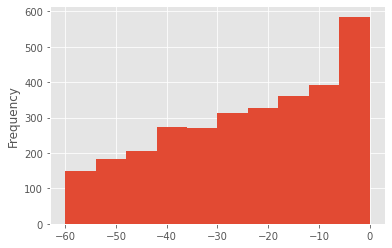

In [20]:
# begin_month (credit = 0)
tt.loc[tt.credit == 0.0, 'begin_month'].plot(kind='hist')

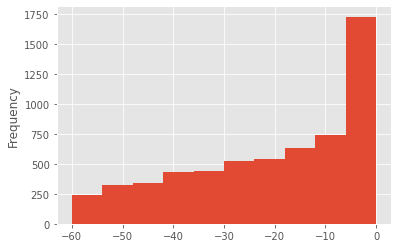

In [21]:
# begin_month (credit = 1)
tt.loc[tt.credit == 1.0, 'begin_month'].plot(kind='hist')

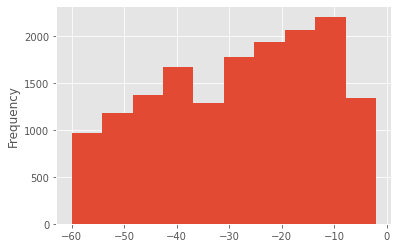

In [22]:
# begin_month (credit = 2)
tt.loc[tt.credit == 2.0, 'begin_month'].plot(kind='hist')

- begin_month와 credit에 대한 분석을 통해, 발급 초기에 신용도를 후하게 평가받는 경향을 확인함.

In [23]:
tt['month_group'] = 0
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')
est.fit(tt['begin_month'].to_numpy().reshape(-1,1))
tt['month_group'] = est.transform(tt['begin_month'].to_numpy().reshape(-1,1))

array([array([-60., -45., -34., -24., -16.,  -8.,   0.])], dtype=object)

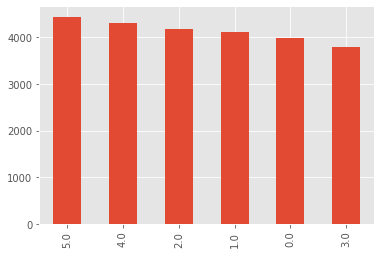

In [24]:
# 비닝 연습, month_group (binning)
tt['month_group'].value_counts().plot(kind='bar')
est.bin_edges_

In [25]:
kk = tt.groupby('id').apply(lambda group: group.sort_values(by='begin_month',axis=0,inplace=False))

In [26]:
ks = pd.concat([tt, ts], axis=0, ignore_index=True)
kk = ks.groupby('id').apply(lambda group: group.sort_values(by='begin_month',axis=0,inplace=False))

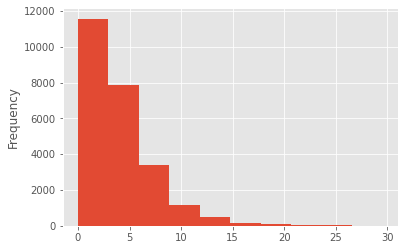

In [27]:
tt_x['tb_divide_cnt'] = 0.0
tt_x['tb_divide_cnt'] = tt_x['total_begin_month'] / tt_x['cnt_card']
tt_x[['total_begin_month','cnt_card','tb_divide_cnt']]
tt_x.tb_divide_cnt.plot(kind='hist')

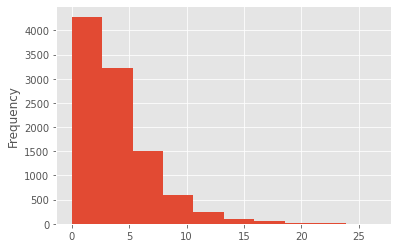

In [28]:
ts_x['tb_divide_cnt'] = 0.0
ts_x['tb_divide_cnt'] = ts_x['total_begin_month'] / ts_x['cnt_card']
ts_x[['total_begin_month','cnt_card','tb_divide_cnt']]
ts_x.tb_divide_cnt.plot(kind='hist')

- tb_divide_cnt = total_begin_month / cnt_card

(최초 발급일 부터 재발급 경과일 / 누적 카드 발급 수)는 train, test 분포가 유사해보임

In [29]:
# 날짜 변환 함수 (일 -> 년)
def days_to_year(x):
  return int(-1*x/365)

tt_x['DAYS_BIRTH'] = tt_x['DAYS_BIRTH'].apply(days_to_year)
tt_x['AGE_GROUP'] = 0

In [30]:
# 업무시작일이 양수인 경우를 0으로 치환 후 직업 유형에도 반영 (업무를 하지 않은 고객)
tt_x.loc[tt_x['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
tt_x['DAYS_EMPLOYED'] = tt_x['DAYS_EMPLOYED'].apply(days_to_year)
tt_x['EMP_GROUP'] = 0

In [31]:
# 나이를 특정 연령대로 비닝
tt_x.loc[tt_x['DAYS_BIRTH'] < 25, 'AGE_GROUP'] = 1
tt_x.loc[(tt_x['DAYS_BIRTH'] >= 25)&(tt_x['DAYS_BIRTH'] < 30), 'AGE_GROUP'] = 2
tt_x.loc[(tt_x['DAYS_BIRTH'] >= 30)&(tt_x['DAYS_BIRTH'] < 35), 'AGE_GROUP'] = 3
tt_x.loc[(tt_x['DAYS_BIRTH'] >= 35)&(tt_x['DAYS_BIRTH'] < 41), 'AGE_GROUP'] = 4
tt_x.loc[(tt_x['DAYS_BIRTH'] >= 41)&(tt_x['DAYS_BIRTH'] < 50), 'AGE_GROUP'] = 5
tt_x.loc[tt_x['DAYS_BIRTH'] >= 50, 'AGE_GROUP'] = 6

In [32]:
# 업무시작일을 특정 기준으로 비닝
tt_x.loc[tt_x['DAYS_EMPLOYED'] < 1, 'EMP_GROUP'] = 1
tt_x.loc[(tt_x['DAYS_EMPLOYED'] >= 1)&(tt_x['DAYS_EMPLOYED'] <= 3), 'EMP_GROUP'] = 2
tt_x.loc[(tt_x['DAYS_EMPLOYED'] >= 4)&(tt_x['DAYS_EMPLOYED'] <= 6), 'EMP_GROUP'] = 3
tt_x.loc[(tt_x['DAYS_EMPLOYED'] >= 7), 'EMP_GROUP'] = 4

In [33]:
est = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
est.fit(tt_x['income_total'].to_numpy().reshape(-1,1))
tt_x['income_group'] = est.transform(tt_x['income_total'].to_numpy().reshape(-1,1))

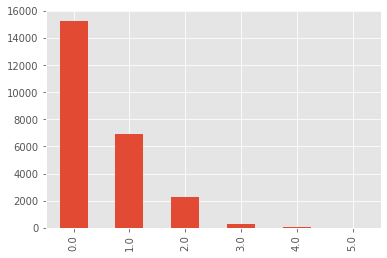

In [34]:
tt_x['income_group'].value_counts().plot(kind='bar')

In [35]:
# optbinning
# y_bin = tt_y.to_numpy().reshape(-1)

x = tt_x['income_total']
y = tt_y
optb = MulticlassOptimalBinning(name='income_total', solver='mip', monotonic_trend='auto', mip_solver='bop')
optb.fit(x, y)
binning_table = optb.binning_table
binning_table.build()

#tt_x['income_total'] = optb.transform(tt_x['income_total'], metric="weighted_mean_woe")
#ts_x['income_total'] = optb.transform(ts_x['income_total'], metric="weighted_mean_woe")

,Bin,Count,Count (%),Event_0.0,Event_1.0,Event_2.0,Event_rate_0.0,Event_rate_1.0,Event_rate_2.0
0,"[-inf, 79200.00)",1435,0.057809,158,370,907,0.110105,0.257840,0.632056
1,"[79200.00, 121700.25)",4924,0.198364,581,1236,3107,0.117994,0.251015,0.630991
2,"[121700.25, 161550.00)",6273,0.252709,782,1534,3957,0.124661,0.244540,0.630799
3,"[161550.00, 195075.00)",2910,0.117230,363,710,1837,0.124742,0.243986,0.631271
4,"[195075.00, 330750.00)",7477,0.301213,946,1716,4815,0.126521,0.229504,0.643975
5,"[330750.00, inf)",1804,0.072675,230,367,1207,0.127494,0.203437,0.669069
6,Special,0,0.000000,0,0,0,0.000000,0.000000,0.000000
7,Missing,0,0.000000,0,0,0,0.000000,0.000000,0.000000
Totals,,24823,1.000000,3060,5933,15830,0.123273,0.239012,0.637715


In [36]:
display(tt_x['income_total'])
optb.transform(tt_x['income_total'], metric="indices")

0        202500.0
1        247500.0
2        450000.0
3        202500.0
4        157500.0
           ...   
24818    225000.0
24819    180000.0
24820    292500.0
24821    171000.0
24822     81000.0
Name: income_total, Length: 24823, dtype: float64

array([4, 4, 5, ..., 4, 3, 1])

In [37]:
kk = tt.groupby('id').apply(lambda group: group.sort_values(by='begin_month',axis=0,inplace=False))

- credit에 대한 income_total, DAYS_BIRTH, DAYS_EMPLOYED 분포 비교 분석
- 연령대에 대하여 신용도 차이가 있음을 확인함

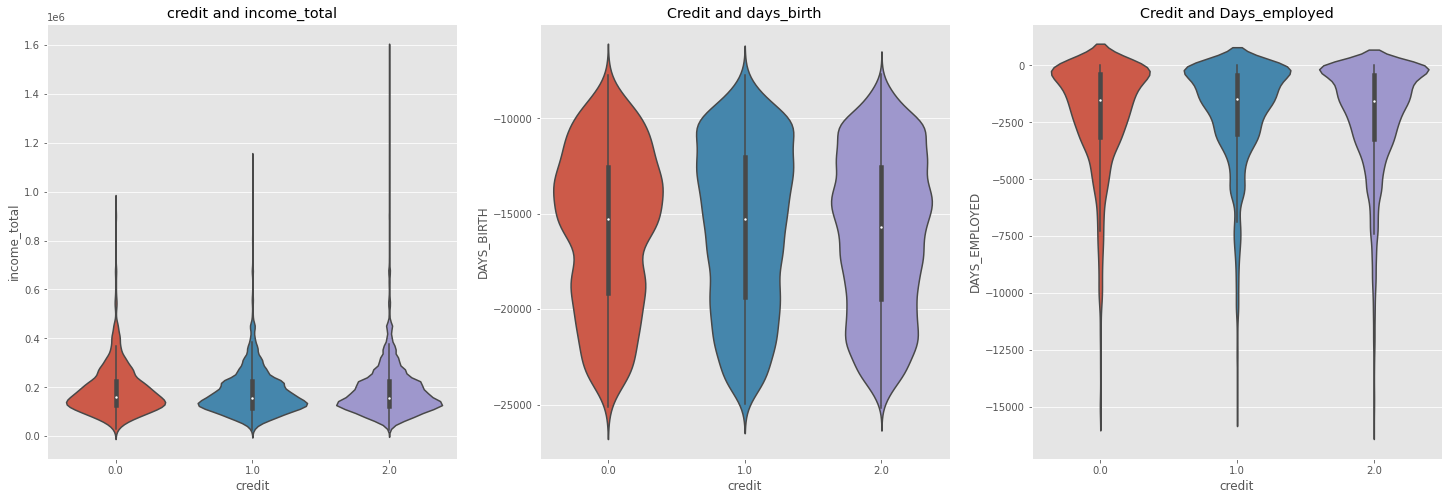

In [38]:
tt.loc[(tt.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0
ts.loc[(ts.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0

f,ax=plt.subplots(1,3,figsize=(25,8))
sns.violinplot("credit","income_total", data=tt,split=True,ax=ax[0])
ax[0].set_title('credit and income_total')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("credit","DAYS_BIRTH",  data=tt,split=True,ax=ax[1])
ax[1].set_title('Credit and days_birth')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("credit","DAYS_EMPLOYED", data=tt,split=True,ax=ax[2])
ax[2].set_title('Credit and Days_employed')
#ax[1].set_yticks(range(0,110,10))
plt.show()

- income_total, DAYS_BIRTH, DAYS_EMPLOYED에 대한 train, test dataset 분포 비교 분석
- 분포가 유사한 것을 확인함

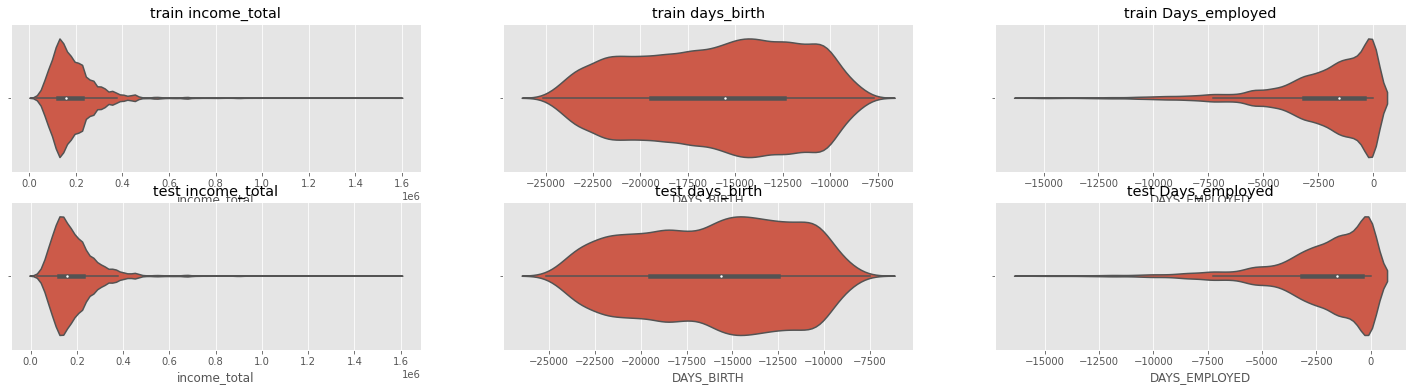

In [39]:
f,ax=plt.subplots(2,3,figsize=(25,6))

sns.violinplot("income_total", data=tt,split=True,ax=ax[0][0])
ax[0][0].set_title('train income_total')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("DAYS_BIRTH",  data=tt,split=True,ax=ax[0][1])
ax[0][1].set_title('train days_birth')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("DAYS_EMPLOYED", data=tt,split=True,ax=ax[0][2])
ax[0][2].set_title('train Days_employed')
#ax[1].set_yticks(range(0,110,10))

sns.violinplot("income_total", data=ts,split=True,ax=ax[1][0])
ax[1][0].set_title('test income_total')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("DAYS_BIRTH",  data=ts,split=True,ax=ax[1][1])
ax[1][1].set_title('test days_birth')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("DAYS_EMPLOYED", data=ts,split=True,ax=ax[1][2])
ax[1][2].set_title('test Days_employed')
#ax[1].set_yticks(range(0,110,10))
plt.show()

- credit에 대한 begin_month, interval_begin_month, cnt_card 분포 비교 분석
- 세 피쳐 모두 신용도에 따라 차이가 있음을 확인함
- 특히, begin_month가 신용도를 결정하는 주요 변수일 것임을 예상해볼 수 있음

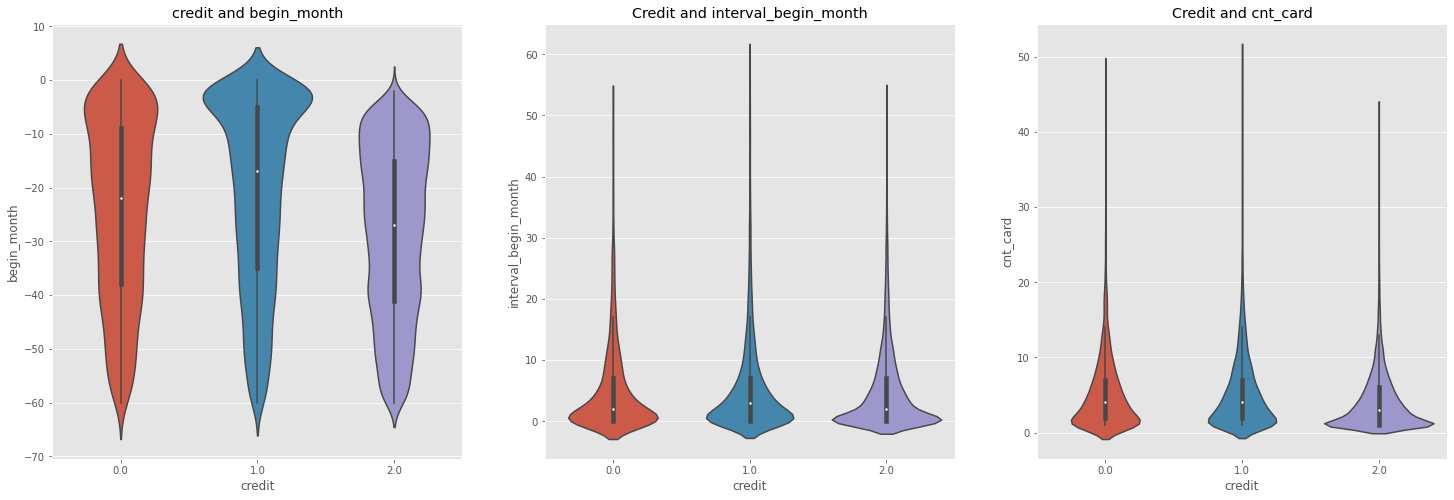

In [40]:
f,ax=plt.subplots(1,3,figsize=(25,8))
sns.violinplot("credit","begin_month", data=tt,split=True,ax=ax[0])
ax[0].set_title('credit and begin_month')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("credit","interval_begin_month",  data=tt,split=True,ax=ax[1])
ax[1].set_title('Credit and interval_begin_month')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("credit","cnt_card", data=tt,split=True,ax=ax[2])
ax[2].set_title('Credit and cnt_card')
#ax[1].set_yticks(range(0,110,10))
plt.show()

- begin_month, interval_begin_month, cnt_card에 대한 train, test dataset 분포 비교 분석
- 분포가 유사한 것을 확인함 (cnt_card에서는 차이가 존재함)

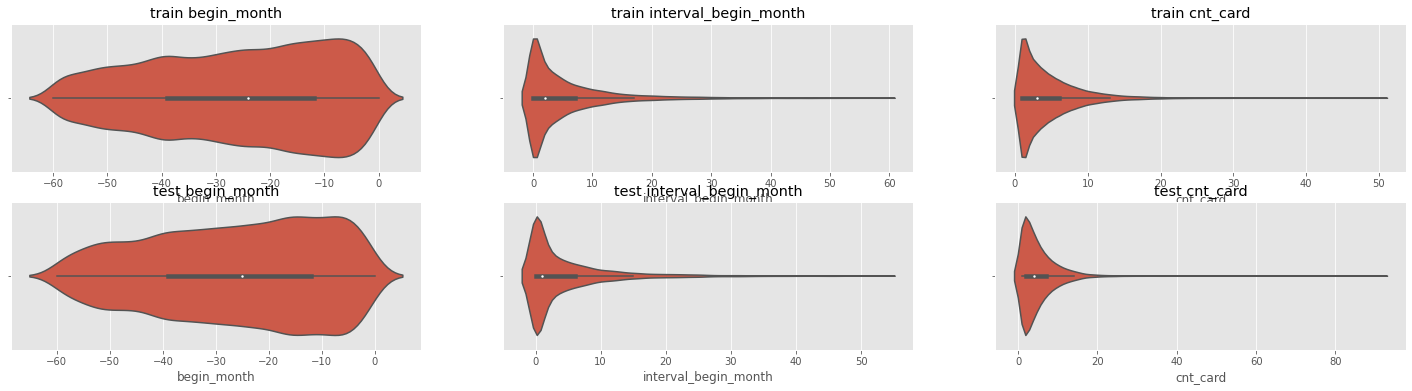

In [41]:
f,ax=plt.subplots(2,3,figsize=(25,6))

sns.violinplot("begin_month", data=tt,split=True,ax=ax[0][0])
ax[0][0].set_title('train begin_month')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("interval_begin_month",  data=tt,split=True,ax=ax[0][1])
ax[0][1].set_title('train interval_begin_month')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("cnt_card", data=tt,split=True,ax=ax[0][2])
ax[0][2].set_title('train cnt_card')
#ax[1].set_yticks(range(0,110,10))

sns.violinplot("begin_month", data=ts,split=True,ax=ax[1][0])
ax[1][0].set_title('test begin_month')
#ax[0].set_yticks(range(0,110,10))
sns.violinplot("interval_begin_month",  data=ts,split=True,ax=ax[1][1])
ax[1][1].set_title('test interval_begin_month')
#ax[1].set_yticks(range(0,110,10))
sns.violinplot("cnt_card", data=ts,split=True,ax=ax[1][2])
ax[1][2].set_title('test cnt_card')
#ax[1].set_yticks(range(0,110,10))
plt.show()

In [42]:
tt.loc[(tt['DAYS_EMPLOYED'] >= 0)&(tt['occyp_type'].isna()), 'occyp_type'] = 'unemployment'
tt.loc[tt['occyp_type'].isna(), 'occyp_type'] = 'None'

- 직업 유형(occyp_type)에 대한 신용도 비교 분석
- 일부 직업의 경우, 분포가 차이가 있음을 확인함


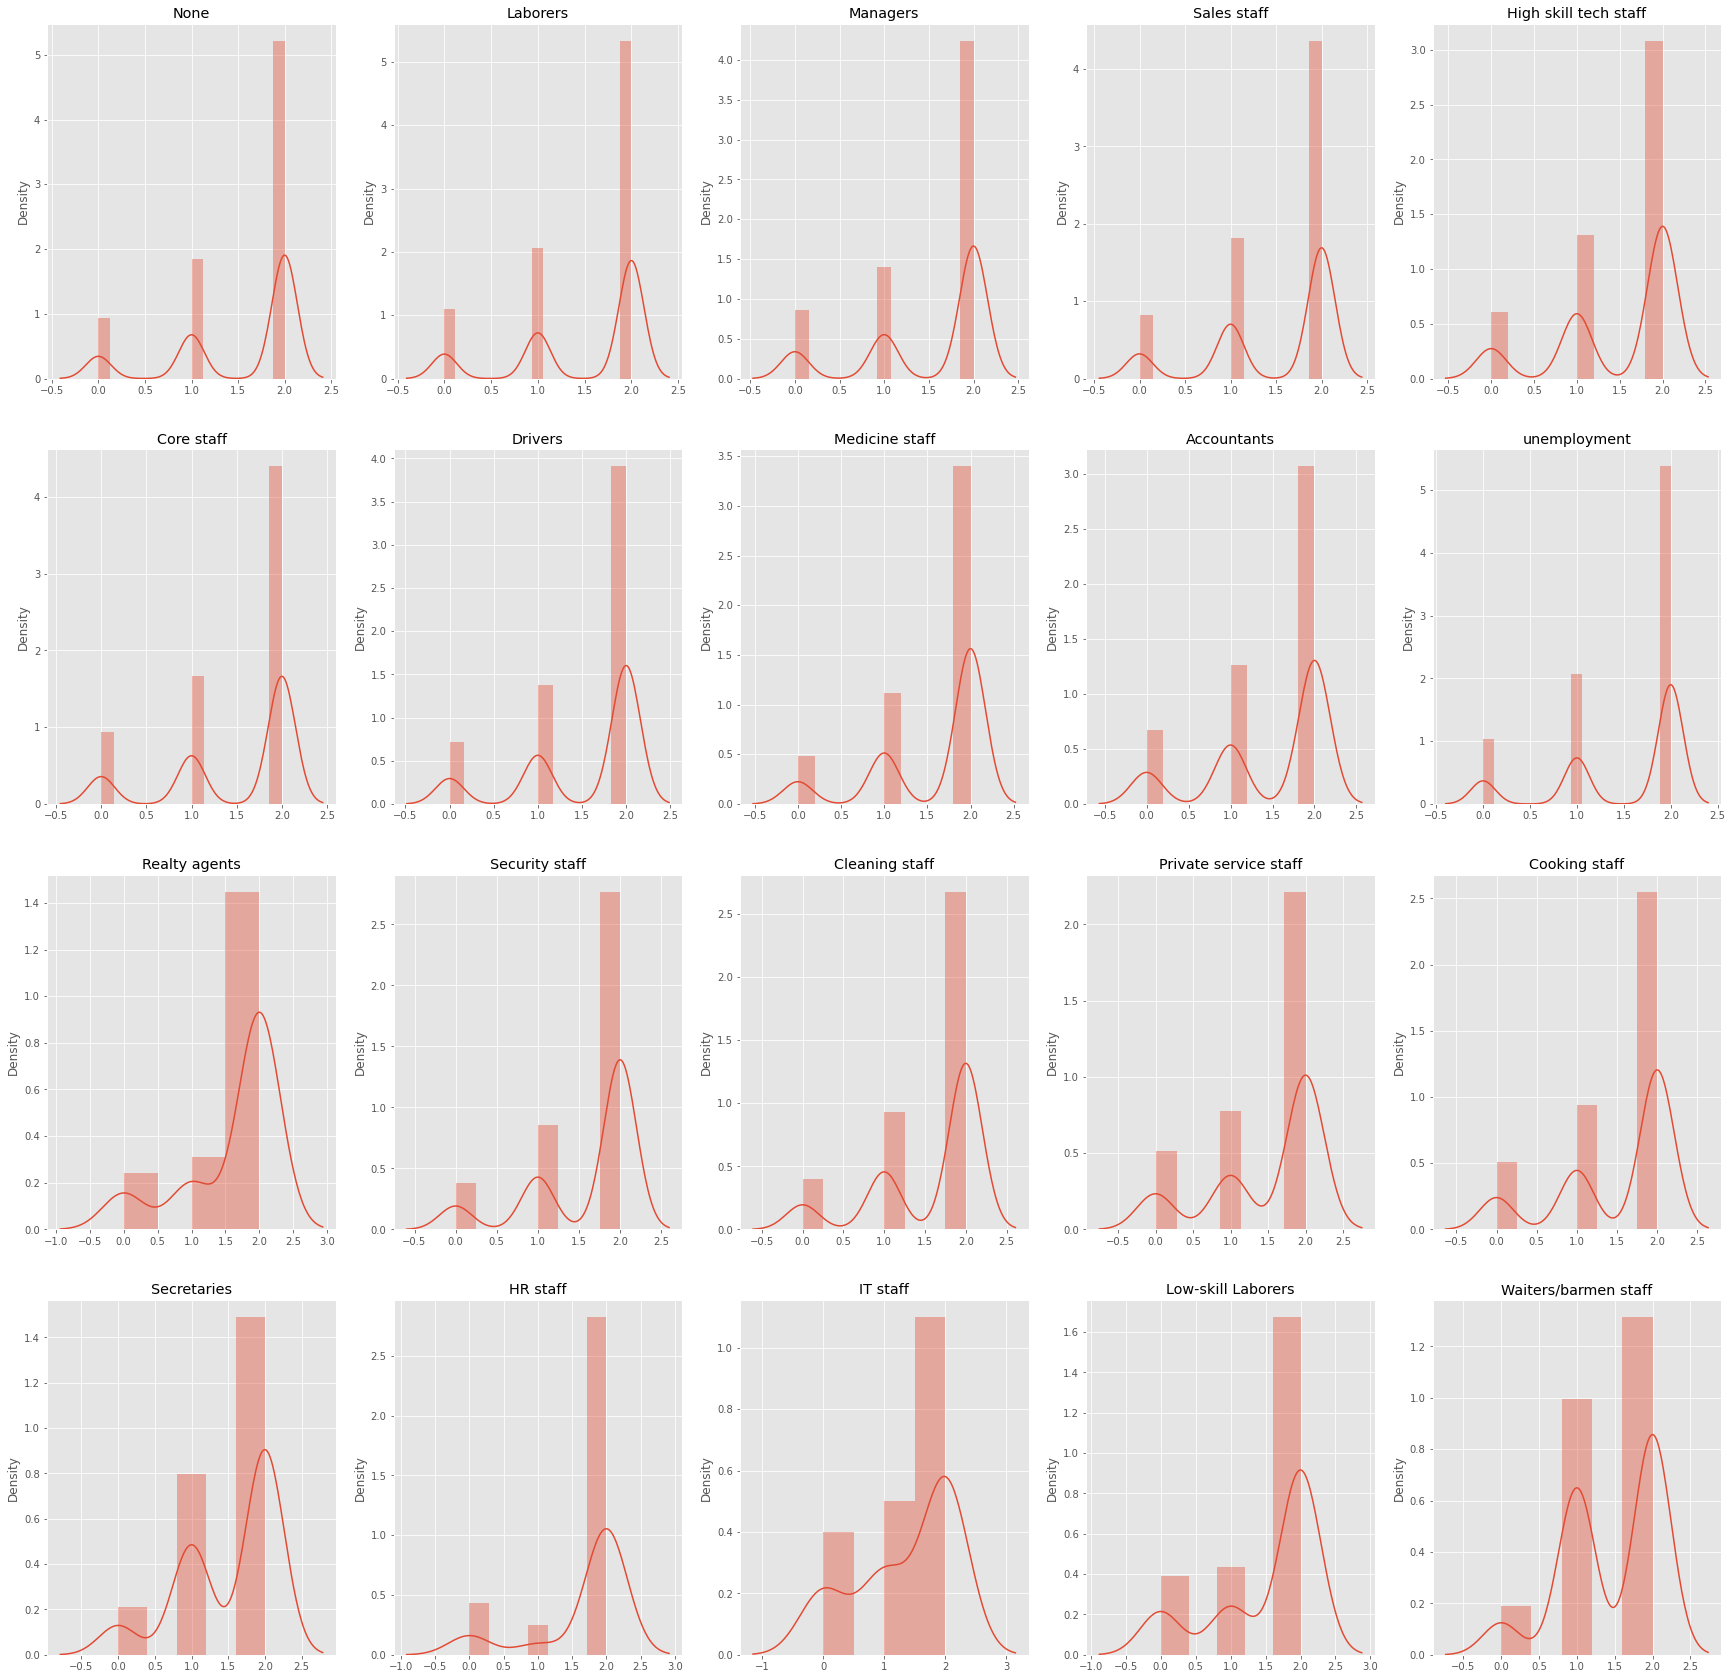

In [43]:
fig, axes = plt.subplots(nrows=4,ncols=5, figsize=(30,30))
i=0
j=0
for k in range(len(tt['occyp_type'].unique())):
  sns.distplot(tt_y[tt['occyp_type']==tt['occyp_type'].unique()[k]], ax=axes[i][j])
  axes[i][j].set_title(tt['occyp_type'].unique()[k])
  j += 1
  if j >= 5:
    i += 1
    j = 0

- income_type에 대한 신용도 비교 분석
- student의 경우, 분포가 차이가 있음을 확인함


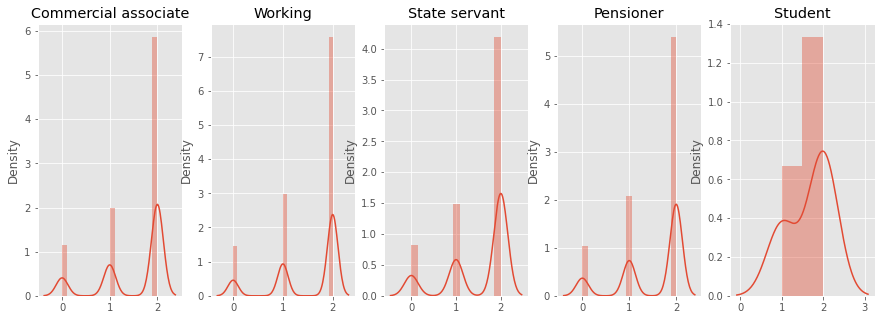

In [44]:
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(15,5))
for k in range(len(tt['income_type'].unique())):
  sns.distplot(tt_y[tt['income_type']==tt['income_type'].unique()[k]], ax=axes[k])
  axes[k].set_title(tt['income_type'].unique()[k])

- edu_type에 대한 신용도 비교 분석
- Academic degree의 경우, 분포가 차이가 있음을 확인함 (student와 관련 여부 파악)


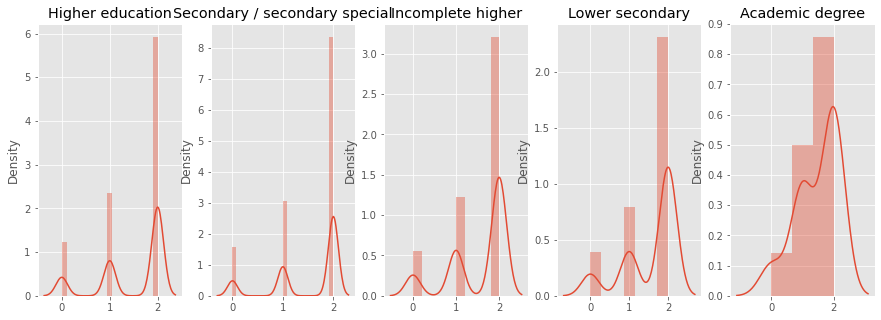

In [45]:
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(15,5))
for k in range(len(tt['edu_type'].unique())):
  sns.distplot(tt_y[tt['edu_type']==tt['edu_type'].unique()[k]], ax=axes[k])
  axes[k].set_title(tt['edu_type'].unique()[k])

- family_type에 대한 신용도 비교 분석
- 분포가 유사한 것을 확인함


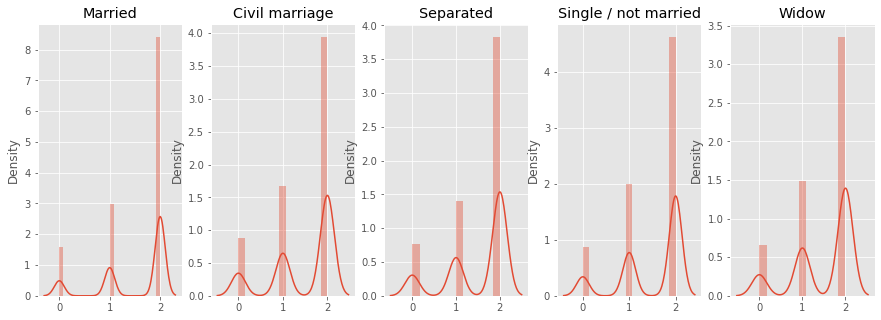

In [46]:
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(15,5))
for k in range(len(tt['family_type'].unique())):
  sns.distplot(tt_y[tt['family_type']==tt['family_type'].unique()[k]], ax=axes[k])
  axes[k].set_title(tt['family_type'].unique()[k])

- house_type에 대한 신용도 비교 분석


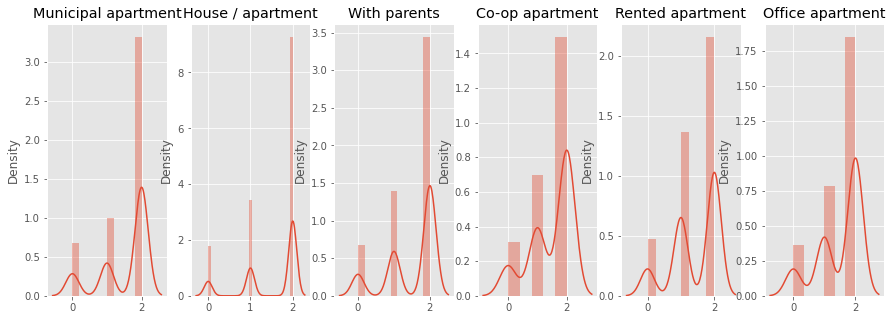

In [47]:
fig, axes = plt.subplots(nrows=1,ncols=6, figsize=(15,5))
for k in range(len(tt['house_type'].unique())):
  sns.distplot(tt_y[tt['house_type']==tt['house_type'].unique()[k]], ax=axes[k])
  axes[k].set_title(tt['house_type'].unique()[k])

- gender에 대한 신용도 비교 분석
- 분포가 유사한 것을 확인함

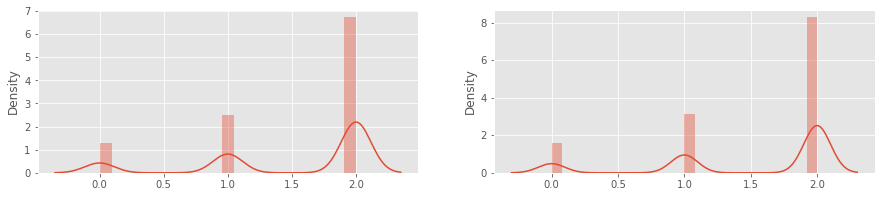

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
sns.distplot(tt_y[tt['gender']=='M'], ax=axes[0])
sns.distplot(tt_y[tt['gender']=='F'], ax=axes[1])

- 재발급여부(reissue)에 대한 신용도 비교 분석
- 분포가 유사한 것을 확인함


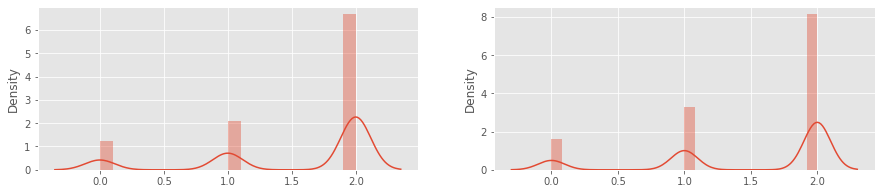

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
sns.distplot(tt_y[tt['reissue']==0], ax=axes[0])
sns.distplot(tt_y[tt['reissue']==1], ax=axes[1])

In [50]:
# house_type 종류
display(tt['house_type'].unique())
# edu_type 빈도 분석
display(tt['edu_type'].value_counts())

array(['Municipal apartment', 'House / apartment', 'With parents',
       'Co-op apartment', 'Rented apartment', 'Office apartment'],
      dtype=object)

Secondary / secondary special    16872
Higher education                  6725
Incomplete higher                  963
Lower secondary                    242
Academic degree                     21
Name: edu_type, dtype: int64

# **5. 데이터 전처리 함수 (preprocess)**

In [51]:
# 모든 피쳐 확인
train_new.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit', 'idx', 'id',
       'interval_begin_month', 'total_begin_month', 'reissue', 'cnt_card',
       'before_credit'],
      dtype='object')

In [52]:
def preprocess(x_train, x_valid, x_test, y_train, y_valid):

    tmp_x_train = x_train.copy()
    tmp_x_valid = x_valid.copy()
    tmp_x_test  = x_test.copy()
    
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_valid = tmp_x_valid.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # 레이블(신용도) 정보는 catboost 인코딩, optbinning에서 사용함
    # data leakage일 경우에는 사용하지 말 것
    tmp_y_train = y_train.copy()
    tmp_y_valid = y_valid.copy()

    tmp_y_train  = tmp_y_train.reset_index(drop=True)
    tmp_y_valid  = tmp_y_valid.reset_index(drop=True)
    
    # 수치형 변수
    numeric_columns = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month','interval_begin_month','cnt_card', 'total_begin_month','tb_divide_cnt']
    
    # 범주형 변수
    categorical_columns = ['gender','car','reality','income_type','edu_type','family_type','house_type','before_credit','occyp_type','reissue', 'id']
    
    # 범주형 변수 (명목형 변수)
    en_categorical_columns = ['income_type','family_type','before_credit','occyp_type','id']
    
    # 범주형 변수 (이진 변수)
    binary_columns = ['gender','car','reality','reissue'] # reissue는 0,1로 인코딩 되어있음
    
    # 범주형 변수 (원핫 인코딩 변수)
    one_columns = ['income_type','family_type','before_credit','occyp_type','id']
    
    # 범주형 변수 (순서형 변수)
    ord_columns = ['edu_type','house_type']

    # 모든 변수
    total_columns = ['family_size','income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month','interval_begin_month','cnt_card', 'total_begin_month',
                     'gender','car','reality','income_type','edu_type','family_type','house_type','before_credit','occyp_type', 'id']
    # FLAG_MOBIL, work_phone, phone, email, child_num 은 삭제되기 때문에 제외함    
    
    # 범주형 변수를 object 타입으로 변환
    for col in categorical_columns:
      tmp_x_train[col] = tmp_x_train[col].astype(object)
      tmp_x_valid[col] = tmp_x_valid[col].astype(object)
      tmp_x_test[col] = tmp_x_test[col].astype(object)

    for col in binary_columns:
      tmp_x_train[col] = tmp_x_train[col].astype(object)
      tmp_x_valid[col] = tmp_x_valid[col].astype(object)
      tmp_x_test[col] = tmp_x_test[col].astype(object)

    # 이진 변수 인코딩
    tmp_x_train['gender'] = tmp_x_train['gender'].replace(['F','M'],[0,1])
    tmp_x_valid['gender'] = tmp_x_valid['gender'].replace(['F','M'],[0,1])
    tmp_x_test['gender'] = tmp_x_test['gender'].replace(['F','M'],[0,1])

    tmp_x_train['car'] = tmp_x_train['car'].replace(['N','Y'],[0,1])
    tmp_x_valid['car'] = tmp_x_valid['car'].replace(['N','Y'],[0,1])
    tmp_x_test['car'] = tmp_x_test['car'].replace(['N','Y'],[0,1])

    tmp_x_train['reality'] = tmp_x_train['reality'].replace(['N','Y'],[0,1])
    tmp_x_valid['reality'] = tmp_x_valid['reality'].replace(['N','Y'],[0,1])
    tmp_x_test['reality'] = tmp_x_test['reality'].replace(['N','Y'],[0,1])

    for col in binary_columns:
      tmp_x_train[col] = tmp_x_train[col].astype(int)
      tmp_x_valid[col] = tmp_x_valid[col].astype(int)
      tmp_x_test[col] = tmp_x_test[col].astype(int)

    # 결측치 처리
    tmp_x_train['occyp_type'] = tmp_x_train['occyp_type'].fillna('None')
    tmp_x_valid['occyp_type'] = tmp_x_valid['occyp_type'].fillna('None')
    tmp_x_test['occyp_type'] = tmp_x_test['occyp_type'].fillna('None')
    
    # 변수 삭제
    tmp_x_train = tmp_x_train.drop(columns=['FLAG_MOBIL'])
    tmp_x_valid = tmp_x_valid.drop(columns=['FLAG_MOBIL'])
    tmp_x_test  = tmp_x_test.drop(columns=['FLAG_MOBIL'])

    tmp_x_train = tmp_x_train.drop(columns=['work_phone'])
    tmp_x_valid = tmp_x_valid.drop(columns=['work_phone'])
    tmp_x_test  = tmp_x_test.drop(columns=['work_phone'])

    tmp_x_train = tmp_x_train.drop(columns=['phone'])
    tmp_x_valid = tmp_x_valid.drop(columns=['phone'])
    tmp_x_test  = tmp_x_test.drop(columns=['phone'])

    tmp_x_train = tmp_x_train.drop(columns=['email'])
    tmp_x_valid = tmp_x_valid.drop(columns=['email'])
    tmp_x_test  = tmp_x_test.drop(columns=['email'])

    """
    tmp_x_train = tmp_x_train.drop(columns=['family_size'])
    tmp_x_valid = tmp_x_valid.drop(columns=['family_size'])
    tmp_x_test  = tmp_x_test.drop(columns=['family_size'])
    """
    """
    tmp_x_train = tmp_x_train.drop(columns=['child_num'])
    tmp_x_valid = tmp_x_valid.drop(columns=['child_num'])
    tmp_x_test  = tmp_x_test.drop(columns=['child_num'])
    """
    """
    tmp_x_train = tmp_x_train.drop(columns=['occyp_type'])
    tmp_x_valid = tmp_x_valid.drop(columns=['occyp_type'])
    tmp_x_test  = tmp_x_test.drop(columns=['occyp_type'])
    """

    # 이상치 처리 - 범주 결합
    idx_nm_1 = tmp_x_train[tmp_x_train['child_num'] > 5].index
    idx_nm_2 = tmp_x_valid[tmp_x_valid['child_num'] > 5].index
    tmp_x_train = tmp_x_train.drop(idx_nm_1)
    tmp_x_valid = tmp_x_valid.drop(idx_nm_2)
    tmp_y_train = tmp_y_train.drop(idx_nm_1)
    tmp_y_valid = tmp_y_valid.drop(idx_nm_2)

    tmp_x_train.loc[tmp_x_train['child_num'] >= 2, 'child_num'] = 2
    tmp_x_valid.loc[tmp_x_valid['child_num'] >= 2, 'child_num'] = 2
    tmp_x_test.loc[tmp_x_test['child_num'] >= 2, 'child_num'] = 2
    

    idx_nm_1 = tmp_x_train[tmp_x_train['family_size'] > 7].index
    idx_nm_2 = tmp_x_valid[tmp_x_valid['family_size'] > 7].index
    tmp_x_train = tmp_x_train.drop(idx_nm_1)
    tmp_x_valid = tmp_x_valid.drop(idx_nm_2)
    tmp_y_train = tmp_y_train.drop(idx_nm_1)
    tmp_y_valid = tmp_y_valid.drop(idx_nm_2)

    tmp_x_train.loc[tmp_x_train['family_size'] >= 4, 'family_size'] = 4
    tmp_x_valid.loc[tmp_x_valid['family_size'] >= 4, 'family_size'] = 4
    tmp_x_test.loc[tmp_x_test['family_size'] >= 4, 'family_size'] = 4


    tmp_x_train.loc[tmp_x_train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
    tmp_x_valid.loc[tmp_x_valid['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
    tmp_x_test.loc[tmp_x_test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

    # 범주형 변수 결합
    tmp_x_train.loc[(tmp_x_train['DAYS_EMPLOYED'] == 0)&(tmp_x_train['occyp_type'] == 'None'), 'occyp_type'] = 'unemployment'
    tmp_x_valid.loc[(tmp_x_valid['DAYS_EMPLOYED'] == 0)&(tmp_x_valid['occyp_type'] == 'None'), 'occyp_type'] = 'unemployment'
    tmp_x_test.loc[(tmp_x_test['DAYS_EMPLOYED'] == 0)&(tmp_x_test['occyp_type'] == 'None'), 'occyp_type'] = 'unemployment'
    
    """
    tmp_x_train.loc[tmp_x_train['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_train.loc[tmp_x_train['family_type'] == 'Separated', 'family_type'] = 'Single / not married'
    tmp_x_train.loc[tmp_x_train['family_type'] == 'Widow', 'family_type'] = 'Single / not married'
    tmp_x_valid.loc[tmp_x_valid['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_valid.loc[tmp_x_valid['family_type'] == 'Separated', 'family_type'] = 'Single / not married'
    tmp_x_valid.loc[tmp_x_valid['family_type'] == 'Widow', 'family_type'] = 'Single / not married'
    tmp_x_test.loc[tmp_x_test['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_test.loc[tmp_x_test['family_type'] == 'Separated', 'family_type'] = 'Single / not married'
    tmp_x_test.loc[tmp_x_test['family_type'] == 'Widow', 'family_type'] = 'Single / not married'
    """
    """
    tmp_x_train.loc[tmp_x_train['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_train.loc[tmp_x_train['family_type'] == 'Separated', 'family_type'] = 'Widow'
    tmp_x_valid.loc[tmp_x_valid['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_valid.loc[tmp_x_valid['family_type'] == 'Separated', 'family_type'] = 'Widow'
    tmp_x_test.loc[tmp_x_test['family_type'] == 'Civil marriage', 'family_type'] = 'Married'
    tmp_x_test.loc[tmp_x_test['family_type'] == 'Separated', 'family_type'] = 'Widow'
    """
    """
    tmp_x_train.loc[tmp_x_train['income_type'] == 'State servant', 'income_type'] = 'Working'
    tmp_x_train.loc[tmp_x_train['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_valid.loc[tmp_x_valid['income_type'] == 'State servant', 'income_type'] = 'Working'
    tmp_x_valid.loc[tmp_x_valid['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_test.loc[tmp_x_test['income_type'] == 'State servant', 'income_type'] = 'Working'
    tmp_x_test.loc[tmp_x_test['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    """
    """
    tmp_x_train.loc[tmp_x_train['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_valid.loc[tmp_x_valid['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_test.loc[tmp_x_test['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    """
    """
    tmp_x_train.loc[tmp_x_train['income_type'] == 'Pensioner', 'income_type'] = 'State servant'
    tmp_x_train.loc[tmp_x_train['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_valid.loc[tmp_x_valid['income_type'] == 'Pensioner', 'income_type'] = 'State servant'
    tmp_x_valid.loc[tmp_x_valid['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    tmp_x_test.loc[tmp_x_test['income_type'] == 'Pensioner', 'income_type'] = 'State servant'
    tmp_x_test.loc[tmp_x_test['income_type'] == 'Commercial associate', 'income_type'] = 'Working'
    """
    """
    tmp_x_train.loc[tmp_x_train['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_train.loc[tmp_x_train['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    tmp_x_train.loc[tmp_x_train['edu_type'] == 'Academic degree', 'edu_type'] = 'Higher education'
    tmp_x_valid.loc[tmp_x_valid['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_valid.loc[tmp_x_valid['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    tmp_x_valid.loc[tmp_x_valid['edu_type'] == 'Academic degree', 'edu_type'] = 'Higher education'
    tmp_x_test.loc[tmp_x_test['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_test.loc[tmp_x_test['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    tmp_x_test.loc[tmp_x_test['edu_type'] == 'Academic degree', 'edu_type'] = 'Higher education'
    """
    """
    tmp_x_train.loc[tmp_x_train['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_train.loc[tmp_x_train['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    tmp_x_valid.loc[tmp_x_valid['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_valid.loc[tmp_x_valid['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    tmp_x_test.loc[tmp_x_test['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
    tmp_x_test.loc[tmp_x_test['edu_type'] == 'Incomplete higher', 'edu_type'] = 'Higher education'
    """

    tmp_x_train.loc[tmp_x_train['house_type'] == 'Municipal apartment', 'house_type'] = 'House / apartment'
    tmp_x_train.loc[tmp_x_train['house_type'] == 'Office apartment', 'house_type'] = 'House / apartment'
    tmp_x_train.loc[tmp_x_train['house_type'] == 'Co-op apartment', 'house_type'] = 'House / apartment'
    tmp_x_valid.loc[tmp_x_valid['house_type'] == 'Municipal apartment', 'house_type'] = 'House / apartment'
    tmp_x_valid.loc[tmp_x_valid['house_type'] == 'Office apartment', 'house_type'] = 'House / apartment'
    tmp_x_valid.loc[tmp_x_valid['house_type'] == 'Co-op apartment', 'house_type'] = 'House / apartment'
    tmp_x_test.loc[tmp_x_test['house_type'] == 'Municipal apartment', 'house_type'] = 'House / apartment'
    tmp_x_test.loc[tmp_x_test['house_type'] == 'Office apartment', 'house_type'] = 'House / apartment'
    tmp_x_test.loc[tmp_x_test['house_type'] == 'Co-op apartment', 'house_type'] = 'House / apartment'

    # 데이터 분포 변환
    minus_num = ['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']

    # 양수화
    for col in minus_num:
      tmp_x_train[col] = -tmp_x_train[col]
      tmp_x_valid[col] = -tmp_x_valid[col]
      tmp_x_test[col] = -tmp_x_test[col]
    
    # 일 -> 연도 변환
    def days_to_year(x):
      return int(x/365)

    tmp_x_train['DAYS_BIRTH'] = tmp_x_train['DAYS_BIRTH'].apply(days_to_year)
    tmp_x_valid['DAYS_BIRTH'] = tmp_x_valid['DAYS_BIRTH'].apply(days_to_year)
    tmp_x_test['DAYS_BIRTH'] = tmp_x_test['DAYS_BIRTH'].apply(days_to_year)

    tmp_x_train['DAYS_EMPLOYED'] = tmp_x_train['DAYS_EMPLOYED'].apply(days_to_year)
    tmp_x_valid['DAYS_EMPLOYED'] = tmp_x_valid['DAYS_EMPLOYED'].apply(days_to_year)
    tmp_x_test['DAYS_EMPLOYED'] = tmp_x_test['DAYS_EMPLOYED'].apply(days_to_year)   

    """
    # log 변환
    tmp_x_train['interval_begin_month'] = tmp_x_train['interval_begin_month'].map(lambda x : np.log1p(x))
    tmp_x_valid['interval_begin_month'] = tmp_x_valid['interval_begin_month'].map(lambda x : np.log1p(x))
    tmp_x_test['interval_begin_month'] = tmp_x_test['interval_begin_month'].map(lambda x : np.log1p(x))

    tmp_x_train['cnt_card'] = tmp_x_train['cnt_card'].map(lambda x : np.log1p(x))
    tmp_x_valid['cnt_card'] = tmp_x_valid['cnt_card'].map(lambda x : np.log1p(x))
    tmp_x_test['cnt_card'] = tmp_x_test['cnt_card'].map(lambda x : np.log1p(x))

    # sqrt 변환
    tmp_x_train['DAYS_EMPLOYED'] = tmp_x_train['DAYS_EMPLOYED'].map(lambda x : np.sqrt(x))
    tmp_x_valid['DAYS_EMPLOYED'] = tmp_x_valid['DAYS_EMPLOYED'].map(lambda x : np.sqrt(x))
    tmp_x_test['DAYS_EMPLOYED'] = tmp_x_test['DAYS_EMPLOYED'].map(lambda x : np.sqrt(x))
    
    tmp_x_train['total_begin_month'] = tmp_x_train['total_begin_month'].map(lambda x : np.sqrt(x))
    tmp_x_valid['total_begin_month'] = tmp_x_valid['total_begin_month'].map(lambda x : np.sqrt(x))
    tmp_x_test['total_begin_month'] = tmp_x_test['total_begin_month'].map(lambda x : np.sqrt(x))
    
    # box-cox 변환
    tmp_x_train['income_total'] = pd.Series(stats.boxcox(tmp_x_train['income_total'])[0])
    tmp_x_valid['income_total'] = pd.Series(stats.boxcox(tmp_x_valid['income_total'])[0])
    tmp_x_test['income_total'] = pd.Series(stats.boxcox(tmp_x_test['income_total'])[0])
    """
    
    # 범주형 변수 처리    
    tmp_all = pd.concat([tmp_x_train, tmp_x_valid])
    y_all = pd.concat([tmp_y_train, tmp_y_valid])

    # 파생변수 생성
    tmp_x_train['tb_divide_cnt'] = 0.0
    tmp_x_valid['tb_divide_cnt'] = 0.0
    tmp_x_test['tb_divide_cnt'] = 0.0
    tmp_x_train['tb_divide_cnt'] = tmp_x_train['total_begin_month'] / tmp_x_train['cnt_card']
    tmp_x_valid['tb_divide_cnt'] = tmp_x_valid['total_begin_month'] / tmp_x_valid['cnt_card']
    tmp_x_test['tb_divide_cnt'] = tmp_x_test['total_begin_month'] / tmp_x_test['cnt_card']

    # binning (수치형 변수 구간화)
    tmp_x_train['AGE_GROUP'] = 0
    tmp_x_valid['AGE_GROUP'] = 0
    tmp_x_test['AGE_GROUP'] = 0
    tmp_x_train['EMP_GROUP'] = 0
    tmp_x_valid['EMP_GROUP'] = 0
    tmp_x_test['EMP_GROUP'] = 0
    tmp_x_train['income_group'] = 0
    tmp_x_valid['income_group'] = 0
    tmp_x_test['income_group'] = 0
    tmp_x_train['month_group'] = 0.0
    tmp_x_valid['month_group'] = 0.0
    tmp_x_test['month_group'] = 0.0

    tmp_x_train.loc[tmp_x_train['DAYS_BIRTH'] < 25, 'AGE_GROUP'] = 1
    tmp_x_train.loc[(tmp_x_train['DAYS_BIRTH'] >= 25)&(tmp_x_train['DAYS_BIRTH'] < 30), 'AGE_GROUP'] = 2
    tmp_x_train.loc[(tmp_x_train['DAYS_BIRTH'] >= 30)&(tmp_x_train['DAYS_BIRTH'] < 35), 'AGE_GROUP'] = 3
    tmp_x_train.loc[(tmp_x_train['DAYS_BIRTH'] >= 35)&(tmp_x_train['DAYS_BIRTH'] < 41), 'AGE_GROUP'] = 4
    tmp_x_train.loc[(tmp_x_train['DAYS_BIRTH'] >= 41)&(tmp_x_train['DAYS_BIRTH'] < 50), 'AGE_GROUP'] = 5
    tmp_x_train.loc[tmp_x_train['DAYS_BIRTH'] >= 50, 'AGE_GROUP'] = 6

    tmp_x_valid.loc[tmp_x_valid['DAYS_BIRTH'] < 25, 'AGE_GROUP'] = 1
    tmp_x_valid.loc[(tmp_x_valid['DAYS_BIRTH'] >= 25)&(tmp_x_valid['DAYS_BIRTH'] < 30), 'AGE_GROUP'] = 2
    tmp_x_valid.loc[(tmp_x_valid['DAYS_BIRTH'] >= 30)&(tmp_x_valid['DAYS_BIRTH'] < 35), 'AGE_GROUP'] = 3
    tmp_x_valid.loc[(tmp_x_valid['DAYS_BIRTH'] >= 35)&(tmp_x_valid['DAYS_BIRTH'] < 41), 'AGE_GROUP'] = 4
    tmp_x_valid.loc[(tmp_x_valid['DAYS_BIRTH'] >= 41)&(tmp_x_valid['DAYS_BIRTH'] < 50), 'AGE_GROUP'] = 5
    tmp_x_valid.loc[tmp_x_valid['DAYS_BIRTH'] >= 50, 'AGE_GROUP'] = 6

    tmp_x_test.loc[tmp_x_test['DAYS_BIRTH'] < 25, 'AGE_GROUP'] = 1
    tmp_x_test.loc[(tmp_x_test['DAYS_BIRTH'] >= 25)&(tmp_x_test['DAYS_BIRTH'] < 30), 'AGE_GROUP'] = 2
    tmp_x_test.loc[(tmp_x_test['DAYS_BIRTH'] >= 30)&(tmp_x_test['DAYS_BIRTH'] < 35), 'AGE_GROUP'] = 3
    tmp_x_test.loc[(tmp_x_test['DAYS_BIRTH'] >= 35)&(tmp_x_test['DAYS_BIRTH'] < 41), 'AGE_GROUP'] = 4
    tmp_x_test.loc[(tmp_x_test['DAYS_BIRTH'] >= 41)&(tmp_x_test['DAYS_BIRTH'] < 50), 'AGE_GROUP'] = 5
    tmp_x_test.loc[tmp_x_test['DAYS_BIRTH'] >= 50, 'AGE_GROUP'] = 6


    tmp_x_train.loc[tmp_x_train['DAYS_EMPLOYED'] < 1, 'EMP_GROUP'] = 1
    tmp_x_train.loc[(tmp_x_train['DAYS_EMPLOYED'] >= 1)&(tmp_x_train['DAYS_EMPLOYED'] <= 3), 'EMP_GROUP'] = 2
    tmp_x_train.loc[(tmp_x_train['DAYS_EMPLOYED'] >= 4)&(tmp_x_train['DAYS_EMPLOYED'] <= 6), 'EMP_GROUP'] = 3
    tmp_x_train.loc[(tmp_x_train['DAYS_EMPLOYED'] >= 7), 'EMP_GROUP'] = 4

    tmp_x_valid.loc[tmp_x_valid['DAYS_EMPLOYED'] < 1, 'EMP_GROUP'] = 1
    tmp_x_valid.loc[(tmp_x_valid['DAYS_EMPLOYED'] >= 1)&(tmp_x_valid['DAYS_EMPLOYED'] <= 3), 'EMP_GROUP'] = 2
    tmp_x_valid.loc[(tmp_x_valid['DAYS_EMPLOYED'] >= 4)&(tmp_x_valid['DAYS_EMPLOYED'] <= 6), 'EMP_GROUP'] = 3
    tmp_x_valid.loc[(tmp_x_valid['DAYS_EMPLOYED'] >= 7), 'EMP_GROUP'] = 4    

    tmp_x_test.loc[tmp_x_test['DAYS_EMPLOYED'] < 1, 'EMP_GROUP'] = 1
    tmp_x_test.loc[(tmp_x_test['DAYS_EMPLOYED'] >= 1)&(tmp_x_test['DAYS_EMPLOYED'] <= 3), 'EMP_GROUP'] = 2
    tmp_x_test.loc[(tmp_x_test['DAYS_EMPLOYED'] >= 4)&(tmp_x_test['DAYS_EMPLOYED'] <= 6), 'EMP_GROUP'] = 3
    tmp_x_test.loc[(tmp_x_test['DAYS_EMPLOYED'] >= 7), 'EMP_GROUP'] = 4

    tmp_x_train.loc[(tmp_x_train['begin_month'] >= 0)&(tmp_x_train['begin_month'] <= 6), 'month_group'] = 1
    tmp_x_train.loc[(tmp_x_train['begin_month'] > 6), 'month_group'] = 2

    tmp_x_valid.loc[(tmp_x_valid['begin_month'] >= 0)&(tmp_x_valid['begin_month'] <= 6), 'month_group'] = 1
    tmp_x_valid.loc[(tmp_x_valid['begin_month'] > 6), 'month_group'] = 2

    tmp_x_test.loc[(tmp_x_test['begin_month'] >= 0)&(tmp_x_test['begin_month'] <= 6), 'month_group'] = 1
    tmp_x_test.loc[(tmp_x_test['begin_month'] > 6), 'month_group'] = 2
    
    est = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
    est.fit(tmp_all['income_total'].to_numpy().reshape(-1,1))
    tmp_x_train['income_group'] = est.transform(tmp_x_train['income_total'].to_numpy().reshape(-1,1))
    tmp_x_valid['income_group'] = est.transform(tmp_x_valid['income_total'].to_numpy().reshape(-1,1))
    tmp_x_test['income_group'] = est.transform(tmp_x_test['income_total'].to_numpy().reshape(-1,1))

    # optbinning
    """
    y_bin = y_all.to_numpy().reshape(-1)
    for col in numeric_columns:
      x = tmp_all[col]
      y = y_bin
      optb = MulticlassOptimalBinning(name=col, solver='mip', monotonic_trend='auto', mip_solver='bop')
      optb.fit(x, y)
      tmp_x_train[col] = optb.transform(tmp_x_train[col], metric="mean_woe")
      tmp_x_valid[col] = optb.transform(tmp_x_valid[col], metric="mean_woe")
      tmp_x_test[col] = optb.transform(tmp_x_test[col], metric="mean_woe")
    """

    # 이상치 처리 - 수치형 변수 이상치 제거
    for col in numeric_columns:
      tmp_all_2 = pd.concat([tmp_x_train, tmp_x_valid])
      col_mean = tmp_all_2[col].mean()
      col_std = tmp_all_2[col].std()
      indexNames_1 = tmp_x_train[(tmp_x_train[col] < (col_mean - 3*col_std))&(tmp_x_train[col] < (col_mean - 3*col_std))].index
      tmp_x_train = tmp_x_train.drop(indexNames_1)
      tmp_y_train = tmp_y_train.drop(indexNames_1)

    # 원핫 인코딩
    """
    ohe = ce.OneHotEncoder(use_cat_names=True)
    ohe.fit(tmp_all[one_columns])

    tmp_train_cat = ohe.transform(tmp_x_train[one_columns])
    tmp_valid_cat = ohe.transform(tmp_x_valid[one_columns])
    tmp_test_cat = ohe.transform(tmp_x_test[one_columns])
    
    tmp_x_train = pd.concat([tmp_x_train, tmp_train_cat], axis=1)
    tmp_x_valid = pd.concat([tmp_x_valid, tmp_valid_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, tmp_test_cat], axis=1)

    tmp_x_train = tmp_x_train.drop(columns=one_columns)
    tmp_x_valid = tmp_x_valid.drop(columns=one_columns)
    tmp_x_test = tmp_x_test.drop(columns=one_columns)
    """

    # MCA (Multiple Correspondence Analysis)
    """
    mca = prince.MCA(n_components=4, n_iter=10, copy=True, 
                     check_input=True, engine='auto', random_state=42)
    mca = mca.fit(tmp_all[categorical_columns])

    mca_x_train = mca.transform(tmp_x_train[categorical_columns])
    mca_x_valid = mca.transform(tmp_x_valid[categorical_columns])
    mca_x_test = mca.transform(tmp_x_test[categorical_columns])

    tmp_x_train = pd.concat([tmp_x_train, mca_x_train], axis=1)
    tmp_x_valid = pd.concat([tmp_x_valid, mca_x_valid], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, mca_x_test], axis=1)

    tmp_x_train = tmp_x_train.drop(columns=categorical_columns)
    tmp_x_valid = tmp_x_valid.drop(columns=categorical_columns)
    tmp_x_test = tmp_x_test.drop(columns=categorical_columns)
    """

    # catboost 인코딩    
    # data leakage일 경우에는 원핫 인코딩, 라벨 인코딩을 사용할 것.
    cbe = ce.CatBoostEncoder()
    cbe.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = cbe.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = cbe.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = cbe.transform(tmp_x_test[en_categorical_columns])

    # 라벨 인코딩
    """
    lbe = LabelEncoder()
    for col in categorical_columns:
      lbe.fit(tmp_all[col])
      tmp_x_train[col] = lbe.transform(tmp_x_train[col])
      tmp_x_valid[col] = lbe.transform(tmp_x_valid[col])
      
      lbe.classes_=np.array([-99999] + lbe.classes_.tolist())
      tmp_x_test[col][~tmp_x_test[col].isin(lbe.classes_)] = -99999
      tmp_x_test[col] = lbe.transform(tmp_x_test[col])
    """

    # Ordinal 인코딩
    ordinal_cols_mapping = [{
        "col":"edu_type",    
        "mapping": {
                    'Academic degree':5, 
                    'Higher education':4, 
                    'Incomplete higher':3, 
                    'Secondary / secondary special':2, 
                    'Lower secondary':1,
                    }},{
        "col":"house_type",
        "mapping": {
                    'House / apartment':3, 
                    'With parents':2, 
                    'Rented apartment':1,
                    }}
                    ]

    train_ode = tmp_x_train[ord_columns].copy()
    valid_ode = tmp_x_valid[ord_columns].copy()
    tmp_ode = tmp_all[ord_columns].copy()
    test_ode = tmp_x_test[ord_columns].copy()

    ode = ce.OrdinalEncoder(mapping=ordinal_cols_mapping, return_df=True)
    ode.fit(tmp_ode)
    train_ode = ode.transform(train_ode)
    valid_ode = ode.transform(valid_ode)
    test_ode = ode.transform(test_ode)

    tmp_x_train[ord_columns] = train_ode[ord_columns]
    tmp_x_valid[ord_columns] = valid_ode[ord_columns]
    tmp_x_test[ord_columns] = test_ode[ord_columns]
    
    # James-Stein 인코딩
    """
    JSE_encoder = ce.JamesSteinEncoder()
    JSE_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = JSE_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = JSE_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = JSE_encoder.transform(tmp_x_test[en_categorical_columns])
    """

    # count 인코딩
    """
    count_encoder = ce.count.CountEncoder()
    count_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = count_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = count_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = count_encoder.transform(tmp_x_test[en_categorical_columns])
    """

    # Generalized Linear Mixed Model 인코딩
    """
    glmm_encoder = ce.glmm.GLMMEncoder()
    glmm_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = glmm_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = glmm_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = glmm_encoder.transform(tmp_x_test[en_categorical_columns])
    """

    # leave_one_out 인코딩
    """
    loo_encoder = ce.leave_one_out.LeaveOneOutEncoder()
    loo_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = loo_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = loo_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = loo_encoder.transform(tmp_x_test[en_categorical_columns])   
    """

    # MEstimate 인코딩
    """
    me_encoder = ce.m_estimate.MEstimateEncoder()
    me_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = me_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = me_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = me_encoder.transform(tmp_x_test[en_categorical_columns])   
    """

    # Target 인코딩
    """
    tg_encoder = ce.target_encoder.TargetEncoder()
    tg_encoder.fit(tmp_all[en_categorical_columns], y_all)
    tmp_x_train[en_categorical_columns] = tg_encoder.transform(tmp_x_train[en_categorical_columns])
    tmp_x_valid[en_categorical_columns] = tg_encoder.transform(tmp_x_valid[en_categorical_columns])
    tmp_x_test[en_categorical_columns] = tg_encoder.transform(tmp_x_test[en_categorical_columns])  
    """

    # 스케일링
    # min-max
    """
    mm_scaler = MinMaxScaler()
    tmp_x_train[numeric_columns] = mm_scaler.fit_transform(tmp_x_train[numeric_columns])
    tmp_x_valid[numeric_columns] = mm_scaler.transform(tmp_x_valid[numeric_columns])
    tmp_x_test[numeric_columns]  = mm_scaler.transform(tmp_x_test[numeric_columns])
    """
    
    # z-score
    ss_scaler = StandardScaler()
    ss_scaler.fit(tmp_x_train[numeric_columns])
    tmp_x_train[numeric_columns] = ss_scaler.transform(tmp_x_train[numeric_columns])
    tmp_x_valid[numeric_columns] = ss_scaler.transform(tmp_x_valid[numeric_columns])
    tmp_x_test[numeric_columns]  = ss_scaler.transform(tmp_x_test[numeric_columns])
    
    return tmp_x_train, tmp_x_valid, tmp_x_test, tmp_y_train, tmp_y_valid

# **6. 모델링 (제출 모델 : Customized LGBM(Optuna 튜닝 후))**

In [53]:
train_copy = train_new.copy()
test_copy = test_new.copy()

# 인덱스 피쳐를 제거하고, credit을 타겟으로 설정함
train_x = train_copy.drop(['idx', 'credit'], axis=1)
train_y = train_copy[['credit']]
test_x = test_copy.drop(['idx'], axis=1)

### TabNet

- 성능이 좋지 못함.. 튜닝이 필요해 보임

In [59]:
# 랜덤 시드 설정
np.random.seed(0)

# 학습, 검증 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, shuffle=True,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

# 전처리 함수 적용
X_train, X_valid, X_test, y_train, y_valid = preprocess(X_train, X_val, test_x, y_train, y_val)

# 누적 발급 카드 수 피쳐 제거
X_train = X_train.drop(['cnt_card'], axis=1)
X_valid = X_valid.drop(['cnt_card'], axis=1)
X_test = X_test.drop(['cnt_card'], axis=1)

# 라벨 이진화 (딥러닝을 위한)
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.fit_transform(y_valid)

# 모든 변수
features = [ col for col in X_train.columns]

# 범주형 변수
categorical_columns = ['gender','car','reality','income_type','edu_type','family_type','house_type','before_credit','occyp_type','reissue', 'id']

# 범주형 변수 인덱스
cat_idxs = [ i for i, f in enumerate(features) if f in X_train.columns]

# 범주형 변수 차원
cat_dims = [ len(X_train.iloc[:,i].unique()) for i, f in enumerate(features) if f in categorical_columns]

In [60]:
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [61]:
# unsupervised_model = TabNetPretrainer(
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=1e-2),
#     mask_type='sparsemax' # "sparsemax"
# )

# unsupervised_model.fit(
#     X_train=X_train,
#     eval_set=[X_valid],
#     pretraining_ratio=0.8,
# )

# TabNet 모델 생성
clf = TabNetMultiTaskClassifier(#n_steps=1,
                                #cat_idxs=cat_idxs,
                                #cat_dims=cat_dims,
                                cat_emb_dim=3,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='sparsemax', 
                                #lambda_sparse=0
                      )

clf

Device used : cpu


TabNetMultiTaskClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=3, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [62]:
# TabNet 모델 학습
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['logloss'],
    max_epochs=1, patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 0.63699 | valid_logloss: 0.5897  |  0:00:01s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_valid_logloss = 0.5897
Best weights from best epoch are automatically used!


In [63]:
# TabNet 모델 예측 결과 (학습셋) - 각 라벨에 대한 확률값과 logloss 성능 평가 지표
preds_train = clf.predict_proba(X_train)
i = preds_train[0][:,1]
j = preds_train[1][:,1]
k = preds_train[2][:,1]

p_t = pd.DataFrame()
p_t['0'] = i
p_t['1'] = j
p_t['2'] = k
print(f"Train_log_loss: {log_loss(y_true=y_train, y_pred=p_t)}")

# TabNet 모델 예측 결과 (검증셋) - 각 라벨에 대한 확률값과 logloss 성능 평가 지표
preds_valid = clf.predict_proba(X_valid)
i = preds_valid[0][:,1]
j = preds_valid[1][:,1]
k = preds_valid[2][:,1]

p_v = pd.DataFrame()
p_v['0'] = i
p_v['1'] = j
p_v['2'] = k
print(f"Val_log_loss: {log_loss(y_true=y_valid, y_pred=p_v)}")

Train_log_loss: 1.0219422744682338
Val_log_loss: 1.018788815699788


In [64]:
# 피쳐 중요도
clf.feature_importances_

array([1.01571645e-01, 5.02026805e-03, 6.85632521e-02, 2.44844407e-01,
       5.62955191e-03, 1.95743111e-02, 2.60081520e-03, 8.82894892e-03,
       8.04180774e-05, 2.71947138e-02, 2.07326929e-05, 7.42056596e-02,
       6.31312766e-02, 7.76455286e-03, 3.96956446e-02, 4.38922573e-03,
       1.62022927e-03, 1.12630010e-02, 4.20295273e-02, 3.58709966e-03,
       1.92033455e-02, 1.27096213e-02, 5.54041739e-03, 2.30931335e-01])

In [65]:
# TabNet 모델 예측 결과 (평가셋) - 각 라벨에 대한 확률값
preds = clf.predict_proba(X_test)
i = preds[0][:,1]
j = preds[1][:,1]
k = preds[2][:,1]
print(len(i), len(j), len(k))

# 제출 파일 생성
submission = sample_submission.copy()
submission['0'] = i
submission['1'] = j
submission['2'] = k
submission.head(10)

10000 10000 10000


,index,0,1,2
0,26457,0.143524,0.301966,0.609589
1,26458,0.069107,0.284306,0.651675
2,26459,0.000464,0.056276,0.798823
3,26460,0.042898,0.173723,0.641927
4,26461,0.155514,0.222800,0.657913
5,26462,0.041628,0.175968,0.584058
6,26463,0.153099,0.224296,0.615562
7,26464,0.096384,0.238755,0.676079
8,26465,0.036268,0.182568,0.718816
9,26466,0.104220,0.137264,0.676607


In [66]:
# 각 라벨에 대한 확률값에 대한 max 값, min 값
print( max(submission.iloc[:,1]), max(submission.iloc[:,2]), max(submission.iloc[:,3]) )
print( min(submission.iloc[:,1]), min(submission.iloc[:,2]), min(submission.iloc[:,3]) )

0.5751920938491821 0.5062532424926758 0.986613929271698
1.3616586329590064e-05 0.030625957995653152 0.2558453679084778


### Optuna

In [67]:
# Obtuna 함수 생성
def objective(trial: Trial) -> float:
    
    # LightGBM 하이퍼파라미터 탐색 범위 설정
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    # 학습, 검증 데이터셋 분리
    X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, shuffle=True,
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 10086)
    
    # 전처리 함수 적용
    X_train, X_valid, X_test, y_train, y_valid = preprocess(X_train, X_valid, test_x, y_train, y_valid)

    # 누적 발급 카드 수 피쳐 제거
    X_train = X_train.drop(['cnt_card'], axis=1)
    X_valid = X_valid.drop(['cnt_card'], axis=1)
    X_test = X_test.drop(['cnt_card'], axis=1)

    # LightGBM 모델 생성
    model = LGBMClassifier(**params_lgb)

    # LightGBM 모델 학습
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=300,
        verbose=False
        )

    # LightGBM 모델 예측 결과 (검증셋) - 각 라벨에 대한 확률값과 logloss 성능 평가 지표
    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-20 03:21:02,309] A new study created in memory with name: lgbm_parameter_opt
[I 2021-07-20 03:21:12,404] Trial 0 finished with value: 0.6010836540066857 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.6010836540066857.
[I 2021-07-20 03:21:25,172] Trial 1 finished with value: 0.6064483688439737 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 0 with value: 0.6010836540066857.
[I 2021-07-20 03:21:33,591] Trial 2 finished with value: 0.5947597602098218 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.5930485508144899
Best trial: {'reg_alpha': 1.987904330777592e-05, 'reg_lambda': 0.028054003730936226, 'max_depth': 11, 'num_leaves': 141, 'colsample_bytree': 0.5109126733153162, 'subsample': 0.9787092394351908, 'subsample_freq': 8, 'min_child_samples': 95, 'max_bin': 469}


In [68]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [69]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [70]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
)

In [71]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

### Customized (LightGBM)


In [72]:
# 학습, 검증 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, shuffle=True,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

# 전처리 함수 적용 전의 학습, 검증 데이터셋 정보
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

# 전처리 함수 적용
X_train, X_val, X_test, y_train, y_val = preprocess(X_train, X_val, test_x, y_train, y_val)

# 누적 카드 발급 수, 재발급 여부 피쳐 제거
X_train = X_train.drop(['cnt_card','reissue'], axis=1)
X_val = X_val.drop(['cnt_card','reissue'], axis=1)
X_test = X_test.drop(['cnt_card','reissue'], axis=1)

# 전처리 함수 적용 후의 학습, 검증 데이터셋 정보
print("===========")
print("After preprocessing")
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)
print(X_train.dtypes)
lgb_params = study.best_trial.params

# LightGBM 모델 생성 - Optuna로 구한 하이퍼 파라미터를 사용
clf = LGBMClassifier(random_state=10086, **lgb_params)

# LightGBM 모델 생성 - Optuna에서 구한 하이퍼 파라미터를 사용하지 않을 경우
"""
clf = LGBMClassifier(random_state=10086, objective='multiclass', metric='multi_logloss',n_estimators=100)
clf = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=1119, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
"""
# RandomForest, XGBoost, CatBoost 모델 생성

"""
clf = RandomForestClassifier(random_state=10086)
clf = XGBClassifier(random_state=10086, objective='multi:softprob', eval_metric='mlogloss')
clf = CatBoostClassifier(random_state=10086, eval_metric='MultiClass', iterations=300, classes_count=3, objective='MultiClass')
"""

display(clf)

# LightGBM 모델 학습
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# LightGBM 모델 예측 결과 (학습, 검증셋) - 각 라벨에 대한 확률값과 logloss 성능 평가 지표
y_train_pred=clf.predict_proba(X_train)
y_pred=clf.predict_proba(X_val)

print(f"Train_log_loss: {log_loss(to_categorical(y_train['credit']), y_train_pred)}")
print(f"Val_log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(18617, 24)
(18617, 1)
Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'id', 'interval_begin_month',
       'total_begin_month', 'reissue', 'cnt_card', 'before_credit'],
      dtype='object')
Validation set: 
(6206, 24)
(6206, 1)
After preprocessing
Train set: 
(18612, 23)
(18612, 1)
Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'occyp_type', 'family_size', 'begin_month', 'id',
       'interval_begin_month', 'total_begin_month', 'before_credit',
       'tb_divide_cnt', 'AGE_GROUP', 'EMP_GROUP', 'income_group',
       'month_group'],
      dtype='object')
Validation set: 
(6205, 23)
(6205, 1)
gender                    int64
car                     

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5109126733153162, importance_type='split',
               learning_rate=0.1, max_bin=469, max_depth=11,
               min_child_samples=95, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=141, objective=None,
               random_state=10086, reg_alpha=1.987904330777592e-05,
               reg_lambda=0.028054003730936226, silent=True,
               subsample=0.9787092394351908, subsample_for_bin=200000,
               subsample_freq=8)

[1]	training's multi_logloss: 0.863979	valid_1's multi_logloss: 0.867833
[2]	training's multi_logloss: 0.839224	valid_1's multi_logloss: 0.84698
[3]	training's multi_logloss: 0.812545	valid_1's multi_logloss: 0.823285
[4]	training's multi_logloss: 0.794504	valid_1's multi_logloss: 0.808687
[5]	training's multi_logloss: 0.776361	valid_1's multi_logloss: 0.793188
[6]	training's multi_logloss: 0.753329	valid_1's multi_logloss: 0.773748
[7]	training's multi_logloss: 0.732721	valid_1's multi_logloss: 0.756568
[8]	training's multi_logloss: 0.721997	valid_1's multi_logloss: 0.748538
[9]	training's multi_logloss: 0.708969	valid_1's multi_logloss: 0.73824
[10]	training's multi_logloss: 0.695832	valid_1's multi_logloss: 0.727477
[11]	training's multi_logloss: 0.684456	valid_1's multi_logloss: 0.718704
[12]	training's multi_logloss: 0.673603	valid_1's multi_logloss: 0.710035
[13]	training's multi_logloss: 0.660012	valid_1's multi_logloss: 0.699243
[14]	training's multi_logloss: 0.64616	valid_1's 

In [73]:
# 변수 중요도 측정 (Permutation Importance)
"""
perm = PermutationImportance(clf, random_state=10086).fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.to_list())
"""

'\nperm = PermutationImportance(clf, random_state=10086).fit(X_val, y_val)\neli5.show_weights(perm, feature_names=X_val.columns.to_list())\n'

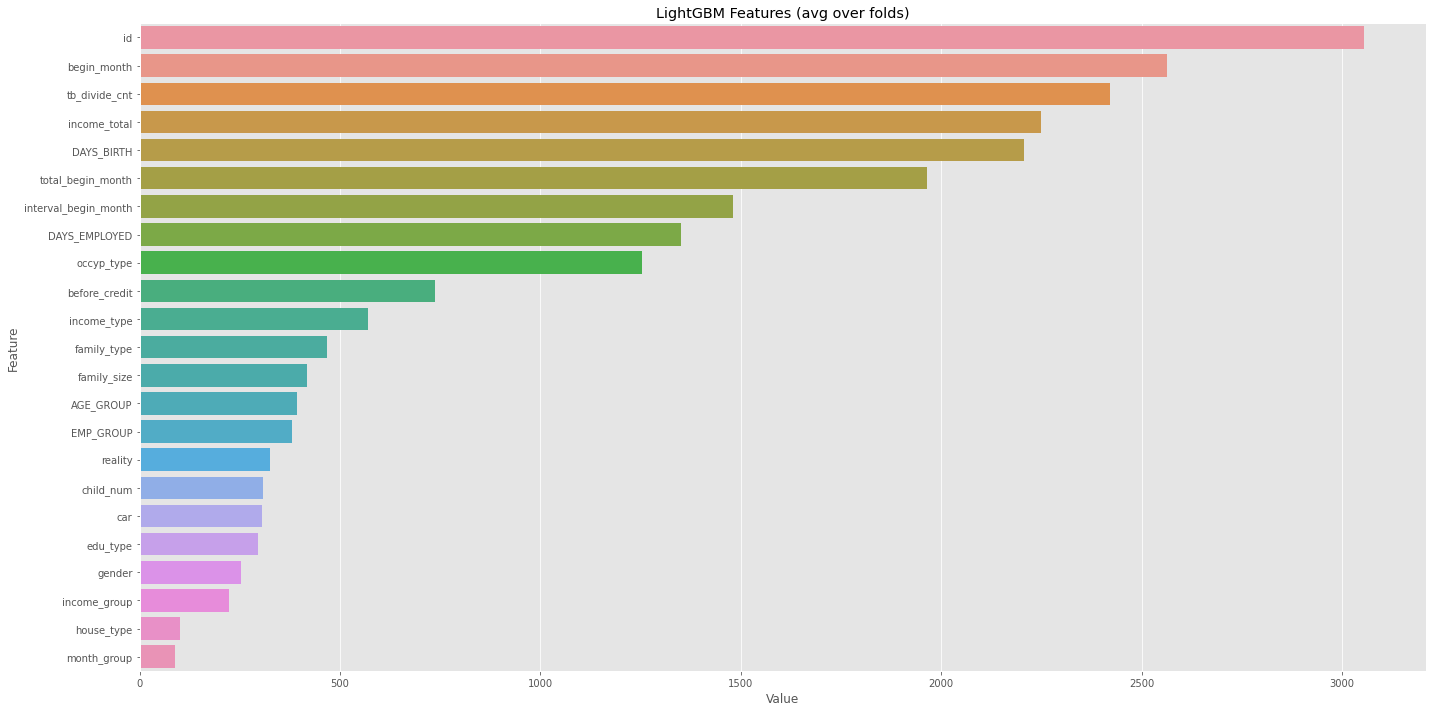

In [74]:
# 피쳐 중요도
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### Stratified K-fold ensemble

In [75]:
# Stratified K-fold ensemble 함수 생성
def run_kfold(clf, train_x, train_y, test_x):
    # StratifiedKFold 객체 생성
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=10086)
    train_outcomes=[]
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    # Fold 별 학습, 검증 데이터셋 분할, 학습 및 예측 결과 진행
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        # Fold 별 학습, 검증 데이터셋 분할
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

        # Fold 별 전처리 함수 적용
        X_train, X_val, X_test, y_train, y_val = preprocess(X_train, X_val, test_x, y_train, y_val)

        # Fold 별 누적 카드 발급 수 피쳐 제거
        X_train = X_train.drop(['cnt_card'], axis=1)
        X_val = X_val.drop(['cnt_card'], axis=1)
        X_test = X_test.drop(['cnt_card'], axis=1)

        # Fold 별 LightGBM 모델 학습
        clf.fit(X_train, y_train)
        
        # Fold 별 LightGBM 모델 예측 결과 (학습, 검증셋) - 각 라벨에 대한 확률값과 logloss 성능 평가 지표
        train_predictions=clf.predict_proba(X_train)
        predictions=clf.predict_proba(X_val)
        
        train_logloss=log_loss(to_categorical(y_train['credit']), train_predictions)
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        train_outcomes.append(train_logloss)
        outcomes.append(logloss)

        print(f"FOLD {n_fold} : train_logloss:{train_logloss}")
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(X_test)
        
    # LightGBM 모델 예측 결과 (평가셋) - 각 라벨에 대한 확률값
    mean_outcome=np.mean(outcomes)
    train_mean_outcome=np.mean(train_outcomes)
    
    # LightGBM 모델 예측 결과 (학습, 검증셋) - logloss 성능 평가 지표
    print("Train_Mean:{}".format(train_mean_outcome))
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

# Stratified K-fold ensemble 함수 실행
my_submission = run_kfold(clf, train_x, train_y, test_x)

FOLD 0 : train_logloss:0.43993411648522057
FOLD 0 : logloss:0.5864179547873759
FOLD 1 : train_logloss:0.4424390781648101
FOLD 1 : logloss:0.5558880288733002
FOLD 2 : train_logloss:0.4423104495921767
FOLD 2 : logloss:0.5868821397055012
FOLD 3 : train_logloss:0.4441417176274838
FOLD 3 : logloss:0.5575734067721111
FOLD 4 : train_logloss:0.4444314122182865
FOLD 4 : logloss:0.5733253471008666
FOLD 5 : train_logloss:0.43907453863004614
FOLD 5 : logloss:0.5987646499000286
FOLD 6 : train_logloss:0.4376112998558258
FOLD 6 : logloss:0.5833444339323568
FOLD 7 : train_logloss:0.4402597086351602
FOLD 7 : logloss:0.586236507965295
FOLD 8 : train_logloss:0.4355606375873686
FOLD 8 : logloss:0.5883233242468185
FOLD 9 : train_logloss:0.44541472283774547
FOLD 9 : logloss:0.5593646573775625
Train_Mean:0.44111776816341236
Mean:0.5776120450661216


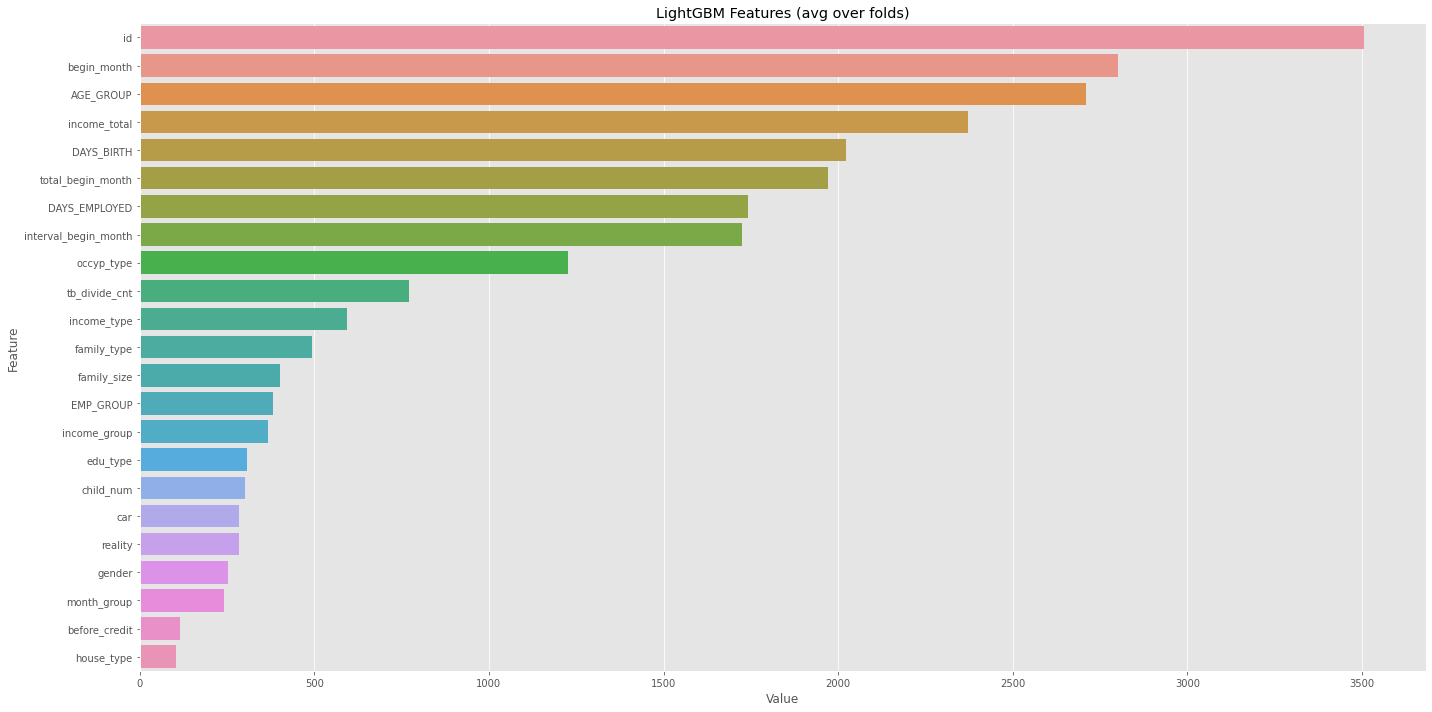

In [76]:
# 피쳐 중요도
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [77]:
# 변수 중요도 측정 (shap values)
"""
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
"""

'\nimport shap\nexplainer = shap.TreeExplainer(clf)\nshap_values = explainer.shap_values(X_train)\nshap.summary_plot(shap_values, X_train)\n'

# **7. 제출 파일 생성**

In [78]:
my_submission

array([[6.99453082e-02, 1.43127338e-01, 7.86927354e-01],
       [4.46908671e-01, 2.15963299e-01, 3.37128030e-01],
       [5.90298393e-04, 1.54919719e-03, 9.97860504e-01],
       ...,
       [8.52016799e-03, 9.99026558e-02, 8.91577176e-01],
       [2.01451683e-01, 3.01276567e-01, 4.97271750e-01],
       [1.17285078e-02, 2.21128082e-01, 7.67143410e-01]])

In [79]:
sample_submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [80]:
sample_submission.loc[:,1:]=my_submission

In [81]:
sample_submission

,index,0,1,2
0,26457,0.069945,0.143127,0.786927
1,26458,0.446909,0.215963,0.337128
2,26459,0.000590,0.001549,0.997861
3,26460,0.042124,0.150161,0.807716
4,26461,0.205053,0.290204,0.504743
...,...,...,...,...
9995,36452,0.026674,0.196832,0.776494
9996,36453,0.202471,0.430246,0.367283
9997,36454,0.008520,0.099903,0.891577
9998,36455,0.201452,0.301277,0.497272


In [82]:
# 각 라벨에 대한 확률값에 대한 max 값, min 값
print( max(sample_submission.iloc[:,1]), max(sample_submission.iloc[:,2]), max(sample_submission.iloc[:,3]) )
print( min(sample_submission.iloc[:,1]), min(sample_submission.iloc[:,2]), min(sample_submission.iloc[:,3]) )

0.993916885639672 0.9904857477117467 0.9990929958410962
0.00028732399367457055 0.0004438771759474335 0.0006776287147636413


In [83]:
sample_submission.to_csv('/content/drive/MyDrive/project/submission/final_0523_lgbm_submission.csv', index=False)